<a href="https://colab.research.google.com/github/YZCUS/py-SpermTracking/blob/main/100322_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries import and Drive connection**

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# import numerical libraries
import pandas as pd
import numpy as np
import math
import statistics

#import graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import sampling, modeling algorithms and dimensionity reduciton
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

Mounted at /content/drive


# **Functions for features extraction**

In [2]:
def included_angle(d1,d2):
    angle1=math.atan2(d1[1],d1[0])
    angle2=math.atan2(d2[1],d2[0])
    if angle1<0:
      angle1+=2*math.pi
    if angle2<0:
      angle2+=2*math.pi
    included_angle=angle2-angle1
    return included_angle

def SDofDV(df):
  df[['dx','dy','dz']]=df[['Position X','Position Y','Position Z']].diff()
  for i in range(1,len(df)):
    df.loc[i,'dv_xy']=included_angle(df.loc[i-1,['dx','dy']],df.loc[i,['dx','dy']])
    df.loc[i,'dv_yz']=included_angle(df.loc[i-1,['dy','dz']],df.loc[i,['dy','dz']])
    df.loc[i,'dv_zx']=included_angle(df.loc[i-1,['dz','dx']],df.loc[i,['dz','dx']])
  return (df['dv_xy'].std()+df['dv_yz'].std()+df['dv_zx'].std())/3

def VCL(df):
  df[['dx','dy','dz']]=df[['Position X','Position Y','Position Z']].diff()
  df['vcl']=(df['dx']**2+df['dy']**2+df['dz']**2)**0.5/0.9
  return df['vcl'].mean()

def VSL(df):
  df[['mdx','mdy','mdz']]=df[['Position X','Position Y','Position Z']].diff(periods=len(df)-1)
  VSL=(df.loc[len(df)-1,'mdx']**2+df.loc[len(df)-1,'mdy']**2+df.loc[len(df)-1,'mdz']**2)**0.5/0.9/(len(df)-1)
  return VSL

def VAP(df):
  df[['apx','apy','apz']]=df[['Position X','Position Y','Position Z']].rolling(3,center=True).mean()
  df.loc[0,['apx','apy','apz']]=np.array(df.loc[0,['Position X','Position Y','Position Z']])
  df.loc[len(df)-1,['apx','apy','apz']]=np.array(df.loc[len(df)-1,['Position X','Position Y','Position Z']])
  df[['adx','ady','adz']]=df[['apx','apy','apz']].diff()
  df['vap']=(df['adx']**2+df['ady']**2+df['adz']**2)**0.5/0.9
  return df['vap'].mean()

# **Read the csv files, Extract parameters, Collect as DataFrames**

Length Filter (Optional)

In [3]:
# the trajectories shorter than this values will be filtered out and won't be included in building classification model
lenfilter=0

In [4]:
# input the trajectories numbers of each groups after pre-processing from imaris file
nVisTJnbList=[254,253,26] #[M2,HTF,SW]
nVisdata=[[],[],[]] #[M2,HTF,SW]
for i,j in enumerate(nVisTJnbList):
  if i==0:
    for k in range(j):
      path='/content/drive/MyDrive/071422_sperm_mod/M2_sperm_mod/M2_sperm_non_vis_{}.csv'.format(k+1)
      df=pd.read_csv(path)
      if len(df)>lenfilter: nVisdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
  elif i==1:
    for k in range(j):
      path='/content/drive/MyDrive/071422_sperm_mod/HTF_sperm_mod/HTF_sperm_non_vis_{}.csv'.format(k+1)
      df=pd.read_csv(path)
      if len(df)>lenfilter: nVisdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
  else:
    for k in range(j):
      path='/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_{}.csv'.format(k+1)
      df=pd.read_csv(path)
      if len(df)>lenfilter: nVisdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])

In [5]:
df_M2_non_vis=pd.DataFrame(np.array(nVisdata[0]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_non_vis=pd.DataFrame(np.array(nVisdata[1]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_invivo_vis=pd.DataFrame(np.array(nVisdata[2]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])

In [6]:
M2_Visdata=[[],[],[],[]]
for i,j in enumerate([26,30,22,23]): #[0p0,0p2,0p4,0p6] Set 1
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/080122_sperm_vis/M2_sperm_vis/M2_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: M2_Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
for i,j in enumerate([23,24,29,22]): #[0p0,0p2,0p4,0p6] Set 2
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/081222_sperm_vis/M2_sperm_vis/M2_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: M2_Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
for i,j in enumerate([43,43,42,39]): #[0p0,0p2,0p4,0p6] Set 3
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/081422_sperm_vis/M2_sperm_vis/M2_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: M2_Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])

In [7]:
df_M2_0p0=pd.DataFrame(np.array(M2_Visdata[0]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_M2_0p2=pd.DataFrame(np.array(M2_Visdata[1]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_M2_0p4=pd.DataFrame(np.array(M2_Visdata[2]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_M2_0p6=pd.DataFrame(np.array(M2_Visdata[3]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])

In [8]:
HTF_Visdata=[[],[],[],[]]
for i,j in enumerate([38,43,36,37]): #[0p0,0p2,0p4,0p6] Set 1
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/080122_sperm_vis/HTF_sperm_vis/HTF_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: HTF_Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
for i,j in enumerate([42,42,35,41]): #[0p0,0p2,0p4,0p6] Set 2
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/081222_sperm_vis/HTF_sperm_vis/HTF_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: HTF_Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])
for i,j in enumerate([37,38,50,40]): #[0p0,0p2,0p4,0p6] Set 3
  for k in range(j):
    path='/content/drive/MyDrive/071422_sperm_mod/081422_sperm_vis/HTF_sperm_vis/HTF_sperm_0p{}_{}.csv'.format(i*2,k+1)
    df=pd.read_csv(path)
    if len(df)>lenfilter: HTF_Visdata[i].append([SDofDV(df),VCL(df),VSL(df),VAP(df),VSL(df)/VCL(df)*100,VSL(df)/VAP(df)*100,VAP(df)/VCL(df)*100,len(df)])

In [9]:
df_HTF_0p0=pd.DataFrame(np.array(HTF_Visdata[0]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_0p2=pd.DataFrame(np.array(HTF_Visdata[1]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_0p4=pd.DataFrame(np.array(HTF_Visdata[2]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])
df_HTF_0p6=pd.DataFrame(np.array(HTF_Visdata[3]),columns=['SDofDV','VCL','VSL','VAP','LIN','STR','WOB','Len'])

# **Data Normalization**

Record the segmentation of each groups

In [10]:
seg=[len(df_M2_non_vis),len(df_HTF_non_vis),len(df_invivo_vis),len(df_HTF_0p0),len(df_HTF_0p2),len(df_HTF_0p4),len(df_HTF_0p6),len(df_M2_0p0),len(df_M2_0p2),len(df_M2_0p4),len(df_M2_0p6)]

In [11]:
for i in range(1,len(seg)):
  seg[i]+=seg[i-1]

In [12]:
seg

[254, 507, 533, 650, 773, 894, 1012, 1104, 1201, 1294, 1378]

Concat all data into one dataframe for dimensionality reduction by PCA

In [13]:
df_all=pd.concat([df_M2_non_vis,df_HTF_non_vis,df_invivo_vis,df_HTF_0p0,df_HTF_0p2,df_HTF_0p4,df_HTF_0p6,df_M2_0p0,df_M2_0p2,df_M2_0p4,df_M2_0p6])
df_all.to_csv('/content/drive/MyDrive/071422_sperm_mod/dataframes_all_bef_pca.csv')

In [14]:
parameters=[['SDofDV','VCL','VSL','VAP','LIN','STR','WOB'],['SDofDV','LIN','STR','WOB']]
mode=1

In [15]:
# Normalize SDofDV as the form of percentage (divide by 2pi)
df_all['SDofDV']=df_all['SDofDV']/math.pi*100/2

In [16]:
df_all

,SDofDV,VCL,VSL,VAP,LIN,STR,WOB,Len
0,7.315353,183.881343,167.271291,179.034866,90.966972,93.429450,97.364346,6.0
1,5.994550,142.856799,141.459066,141.618555,99.021585,99.887381,99.133227,5.0
2,2.217264,149.618903,149.108813,149.163957,99.659074,99.963031,99.695931,6.0
3,3.379577,138.817714,138.235610,138.361588,99.580671,99.908950,99.671421,5.0
4,7.094773,114.613390,107.110981,111.360371,93.454160,96.184109,97.161746,6.0
...,...,...,...,...,...,...,...,...
79,15.550055,34.224575,30.885995,31.528747,90.245077,97.961376,92.123122,15.0
80,18.347932,44.710468,42.154723,43.270009,94.283788,97.422497,96.778251,23.0
81,27.038112,46.742540,42.858092,44.162515,91.689695,97.046310,94.480351,20.0
82,4.862230,69.125324,68.454557,68.562258,99.029637,99.842916,99.185441,9.0


In [17]:
# Convert values into the range of [0,1]
mm=MinMaxScaler()
Allmtrx=np.array(df_all.loc[:,parameters[mode]])
mm_All=mm.fit_transform(Allmtrx)

# **Principal Component Analysis**

In [18]:
pca = PCA(n_components=len(parameters[mode]))
principalComponents = pca.fit_transform(mm_All)
pca.explained_variance_ratio_

array([0.76835929, 0.17618144, 0.05440791, 0.00105135])

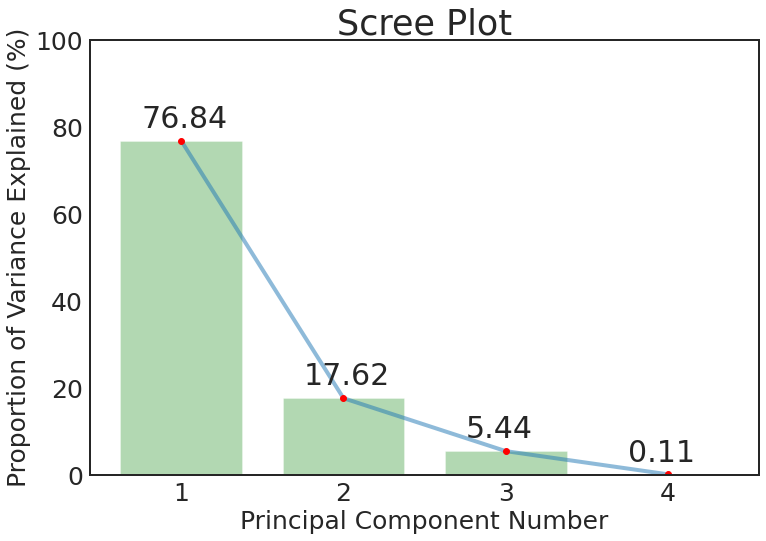

In [19]:
# Scree Plot for evulation of informaiton loss during PCA to determine dimensionality
importance = 100*pca.explained_variance_ratio_
sns.set_style('white')
fig=plt.figure(figsize = (12,8))
ax=fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.scatter(range(1,len(parameters[mode])+1),importance,c='r',s=35,zorder=2)
plt.plot(range(1,len(parameters[mode])+1),importance,linewidth=4,zorder=1,alpha=0.5)
plt.bar(range(1,len(parameters[mode])+1),importance,color='g',alpha=0.3,width=0.75)
for i in range(1,len(parameters[mode])+1):
    plt.annotate(round(importance[i-1],2),(i,importance[i-1]),textcoords="offset points",xytext=(-40,13),size=30)
plt.title('Scree Plot',fontsize=35)
plt.xlabel('Principal Component Number',fontsize=25)
plt.xticks(range(1,len(parameters[mode])+1),fontsize=25)
plt.ylabel('Proportion of Variance Explained (%)',fontsize=25)
plt.yticks([0,20,40,60,80,100],fontsize=25)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Scree')
plt.show()

In [20]:
# Factor analysis
pca = PCA(n_components=2)
PrincipalComponents_all=pca.fit_transform(mm_All)
principalDF_all=pd.DataFrame(data=PrincipalComponents_all,columns=['principal component 1','principal component 2'])
pca.components_

array([[ 0.52688562, -0.55679814, -0.42433493, -0.48198261],
       [ 0.83460618,  0.35928646,  0.38711212,  0.15649273]])

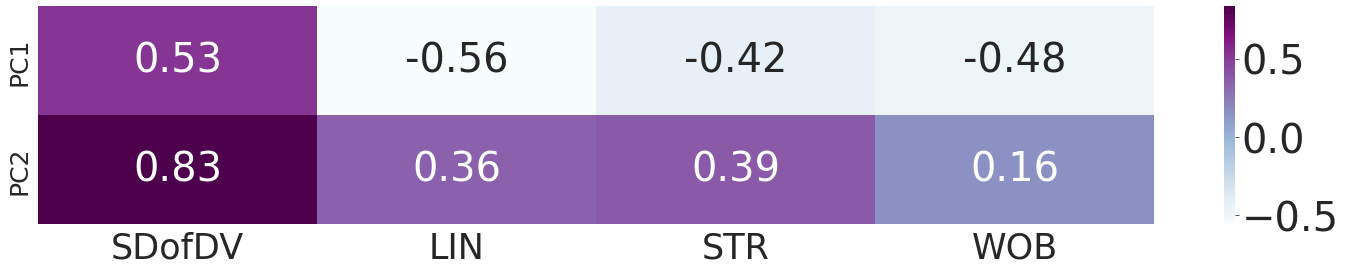

In [21]:
# Print out the projection matrix and visualize the parameters by heatmap
df_cm = pd.DataFrame(pca.components_, columns=parameters[mode], index=['PC1','PC2'])
plt.figure(figsize = (25,4))
ax = sns.heatmap(df_cm, annot=True, cmap="BuPu",annot_kws={"fontsize":40})
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=35)
ax.figure.axes[-1].yaxis.set_tick_params(labelsize=40)
# plt.title('Factors Analysis', fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Mtrx')
plt.show()

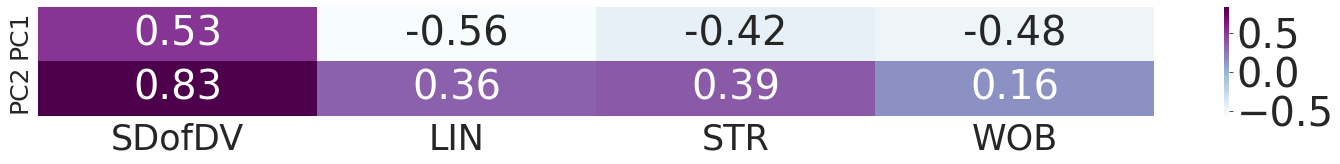

In [22]:
# Print out the projection matrix and visualize the parameters by heatmap
df_cm = pd.DataFrame(pca.components_, columns=parameters[mode], index=['PC1','PC2'])
plt.figure(figsize = (25,2))
ax = sns.heatmap(df_cm, annot=True, cmap="BuPu",annot_kws={"fontsize":40})
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=35)
ax.figure.axes[-1].yaxis.set_tick_params(labelsize=40)
# plt.title('Factors Analysis', fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Mtrx_thinner')
plt.show()

Divide the PCA result based on each dataset

In [23]:
mm_pca_M2_non=np.array(principalDF_all[:seg[0]])  #0
mm_pca_HTF_non=np.array(principalDF_all[seg[0]:seg[1]]) #1
mm_pca_invivo=np.array(principalDF_all[seg[1]:seg[2]]) #2
mm_pca_HTF_0p0=np.array(principalDF_all[seg[2]:seg[3]]) #3
mm_pca_HTF_0p2=np.array(principalDF_all[seg[3]:seg[4]]) #4
mm_pca_HTF_0p4=np.array(principalDF_all[seg[4]:seg[5]]) #5
mm_pca_HTF_0p6=np.array(principalDF_all[seg[5]:seg[6]]) #6
mm_pca_M2_0p0=np.array(principalDF_all[seg[6]:seg[7]]) #7
mm_pca_M2_0p2=np.array(principalDF_all[seg[7]:seg[8]]) #8
mm_pca_M2_0p4=np.array(principalDF_all[seg[8]:seg[9]]) #9
mm_pca_M2_0p6=np.array(principalDF_all[seg[9]:seg[10]]) #10

In [24]:
plotList=[
    [mm_pca_M2_non,0,seg[0]],
    [mm_pca_HTF_non,seg[0],seg[1]],
    [mm_pca_invivo,seg[1],seg[2],'Vivo'],
    [mm_pca_HTF_0p0,seg[2],seg[3],'1.0 mPa•s_HTF'],
    [mm_pca_HTF_0p2,seg[3],seg[4],'3.5 mPa•s_HTF'],
    [mm_pca_HTF_0p4,seg[4],seg[5],'10.5 mPa•s_HTF'],
    [mm_pca_HTF_0p6,seg[5],seg[6],'29.4 mPa•s_HTF'],
    [mm_pca_M2_0p0,seg[6],seg[7],'1.0 mPa•s_M2'],
    [mm_pca_M2_0p2,seg[7],seg[8],'3.5 mPa•s_M2'],
    [mm_pca_M2_0p4,seg[8],seg[9],'10.5 mPa•s_M2'],
    [mm_pca_M2_0p6,seg[9],seg[10],'29.4 mPa•s_M2']
]

In [25]:
# Combine the PCA result with original data
df_all=pd.DataFrame(df_all).reset_index(drop=True)
principalDF_all=pd.concat([principalDF_all,df_all],axis=1)

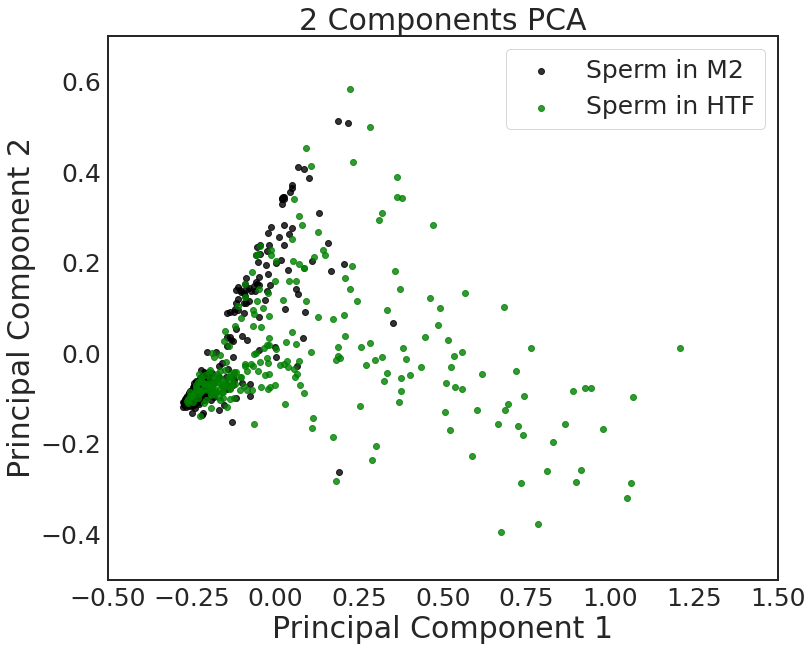

In [26]:
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA', fontsize = 30)
kdot=ax.scatter(principalDF_all.loc[:seg[0],'principal component 1'],principalDF_all.loc[:seg[0],'principal component 2'],c='k',alpha=0.8)
gdot=ax.scatter(principalDF_all.loc[seg[0]:seg[1],'principal component 1'],principalDF_all.loc[seg[0]:seg[1],'principal component 2'],c='g',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
ax.legend([kdot,gdot],['Sperm in M2','Sperm in HTF'],fontsize=25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 0.7)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/PCA_Only')
plt.show()

# **K-mean clustering with Bootstrap**

In [27]:
# Configure the Bootstrap
n_iterations = 2000
n_size = int(len(mm_pca_HTF_non)*0.8)
data=mm_pca_HTF_non

In [28]:
def swap(arr):
  for i in range(len(arr)):
    if arr[i]:
      arr[i]=0
    else:
      arr[i]=1

In [29]:
# Run Bootstrap
stats= list()
for i in range(n_iterations):
  # prepare train set and test set
  train = resample(data,n_samples=n_size)
  test = np.array([x for x in data if x.tolist() not in train.tolist()])
  # fit model
  kmeans = KMeans(n_clusters=2,random_state=0).fit(train)
  center_sort = kmeans.cluster_centers_[kmeans.cluster_centers_[:,0].argsort()]
  temp=[center_sort[0],center_sort[1]]
  label_sort = np.sort(kmeans.labels_)
  mid = label_sort[len(label_sort)//2]
  if mid==1:
    swap(kmeans.labels_)
  kp=(sum(kmeans.labels_)/len(kmeans.labels_)*100)  #else (100-sum(kmeans.labels_)/len(kmeans.labels_)*100)
  temp.append(kp)
  # evaluate model
  predictions = kmeans.predict(test)
  if mid==1:
    swap(predictions)
  pp=(sum(predictions)/len(predictions)*100) # else(100-sum(predictions)/len(predictions)*100)
  temp.append(pp)
  diff=abs(pp-kp)/kp*100
  weight=kp/abs(pp-kp)
  temp.append(diff)
  temp.append(weight)
  control=kmeans.predict(mm_pca_M2_non)
  HTF=kmeans.predict(mm_pca_HTF_non)
  invivo=kmeans.predict(mm_pca_invivo)
  VS1=kmeans.predict(mm_pca_HTF_0p0)
  VS2=kmeans.predict(mm_pca_HTF_0p2)
  VS3=kmeans.predict(mm_pca_HTF_0p4)
  VS4=kmeans.predict(mm_pca_HTF_0p6)
  VS5=kmeans.predict(mm_pca_M2_0p0)
  VS6=kmeans.predict(mm_pca_M2_0p2)
  VS7=kmeans.predict(mm_pca_M2_0p4)
  VS8=kmeans.predict(mm_pca_M2_0p6)
  for k in [control,HTF,invivo,VS1,VS2,VS3,VS4,VS5,VS6,VS7,VS8]:
    if mid==1:
      swap(k)
    temp.append(k)
  stats.append(temp)

In [30]:
df_bs=pd.DataFrame(np.array(stats,dtype=object),columns=['LC','RC','Label (%)','Pred (%)','Diff (%)','Weight','control','mod_agg','invivo','HTF_0p0','HTF_0p2','HTF_0p4','HTF_0p6','M2_0p0','M2_0p2','M2_0p4','M2_0p6'])

# **Histogram and CI**

**Histogram**

In [31]:
df_bs.loc[:,'Label (%)'].mean(),df_bs.loc[:,'Label (%)'].std(),df_bs.loc[:,'Pred (%)'].mean(),df_bs.loc[:,'Pred (%)'].std()

(26.205940594059392, 3.928285268768979, 26.136320949111997, 3.8197362372757495)

In [32]:
df_bs.loc[:,'Label (%)'].max(),df_bs.loc[:,'Label (%)'].min(),df_bs.loc[:,'Pred (%)'].max(),df_bs.loc[:,'Pred (%)'].min()

(38.11881188118812, 12.871287128712872, 41.17647058823529, 13.043478260869565)

In [33]:
df_bs.loc[:,'Diff (%)'].mean(),df_bs.loc[:,'Diff (%)'].std()

(18.29851754624822, 15.274874912429237)

In [34]:
df_bs.loc[:,'Diff (%)'].max(),df_bs.loc[:,'Diff (%)'].min()

(107.97940797940797, 0.03668378576668102)

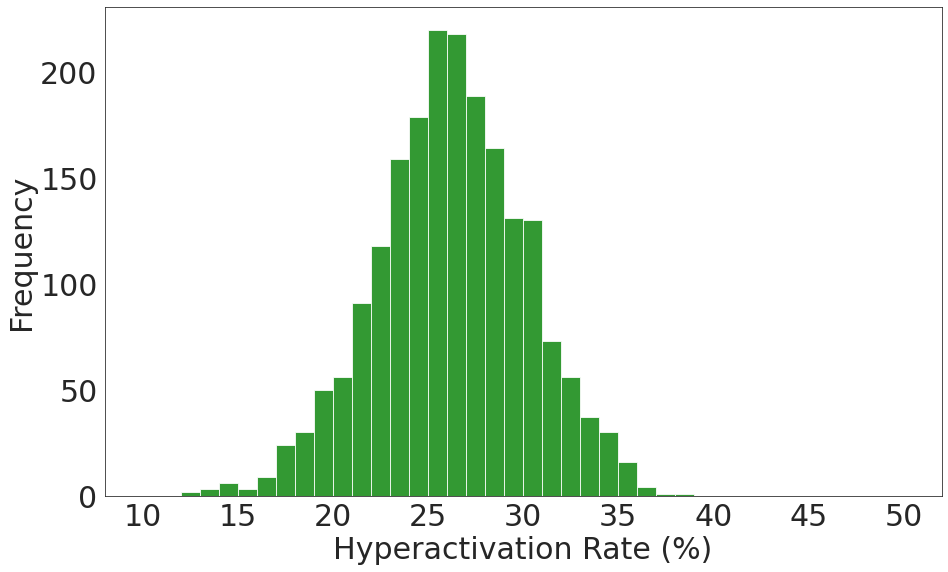

In [35]:
sns.set_style('white')
fig=plt.figure(figsize=(15,9))
plt.hist(df_bs['Label (%)'],range=[10,50],color='g',alpha=0.8,bins=40)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hyperactivation Rate (%)',fontsize=30)
plt.ylabel('Frequency',fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/BS_hist_2000_label')
plt.show()

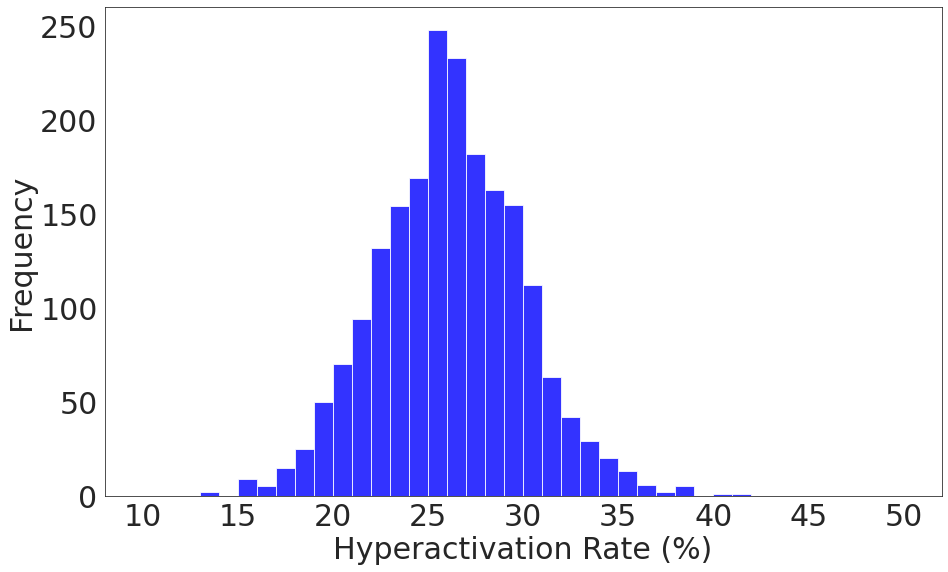

In [36]:
sns.set_style('white')
fig=plt.figure(figsize=(15,9))
plt.hist(df_bs['Pred (%)'],range=[10,50],color='b',alpha=0.8,bins=40)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hyperactivation Rate (%)',fontsize=30)
plt.ylabel('Frequency',fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/BS_hist_2000_pred')
plt.show()

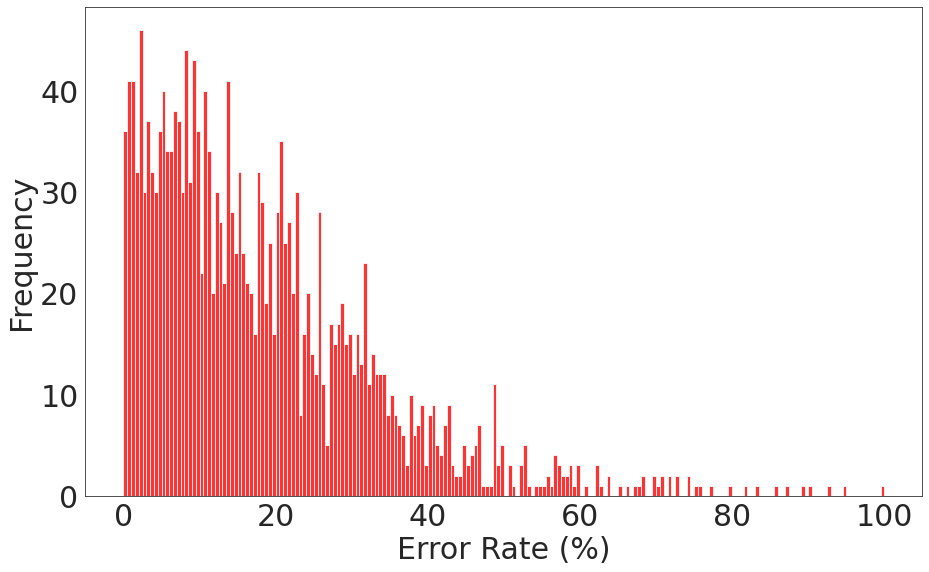

In [37]:
sns.set_style('white')
fig=plt.figure(figsize=(15,9))
plt.hist(df_bs['Diff (%)'],range=[0,100],color='r',alpha=0.8,bins=200)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Error Rate (%)',fontsize=30)
plt.ylabel('Frequency',fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/BS_hist_2000_diff')
plt.show()

**Confidence Intervals**

In [38]:
# 95% confidence intervals

a = 0.95
p = ((1-a)/2)*100
lower = max(0,np.percentile(df_bs['Label (%)'],p))
p = (a+((1-a)/2))*100
upper = min(100,np.percentile(df_bs['Label (%)'],p))
print(a*100,' confidence interval ',lower ,' % and',upper, '%')

95.0  confidence interval  18.316831683168317  % and 34.15841584158416 %


In [39]:
# 95% confidence intervals

a = 0.95
p = ((1-a)/2)*100
lower = max(0,np.percentile(df_bs['Pred (%)'],p))
p = (a+((1-a)/2))*100
upper = min(100,np.percentile(df_bs['Pred (%)'],p))
print(a*100,' confidence interval ',lower ,' % and',upper, '%')

95.0  confidence interval  18.74853971962617  % and 33.91343167701863 %


In [40]:
# 95% confidence intervals

a = 0.95
p = ((1-a)/2)*100
lower = max(-100,np.percentile(df_bs['Diff (%)'],p))
p = (a+((1-a)/2))*100
upper = min(100,np.percentile(df_bs['Diff (%)'],p))
print(a*100,' confidence interval ',lower ,' % and',upper, '%')

95.0  confidence interval  0.8019827863577785  % and 57.41515802938503 %


# **Majority_Vote_agg**

In [41]:
r=[]
for col in ['control','mod_agg','invivo','HTF_0p0','HTF_0p2','HTF_0p4','HTF_0p6','M2_0p0','M2_0p2','M2_0p4','M2_0p6']:
  r.append(df_bs[col].mean())

In [42]:
r[2]

array([0.113 , 1.    , 0.8595, 0.0665, 1.    , 1.    , 1.    , 1.    ,
       0.9665, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    ])

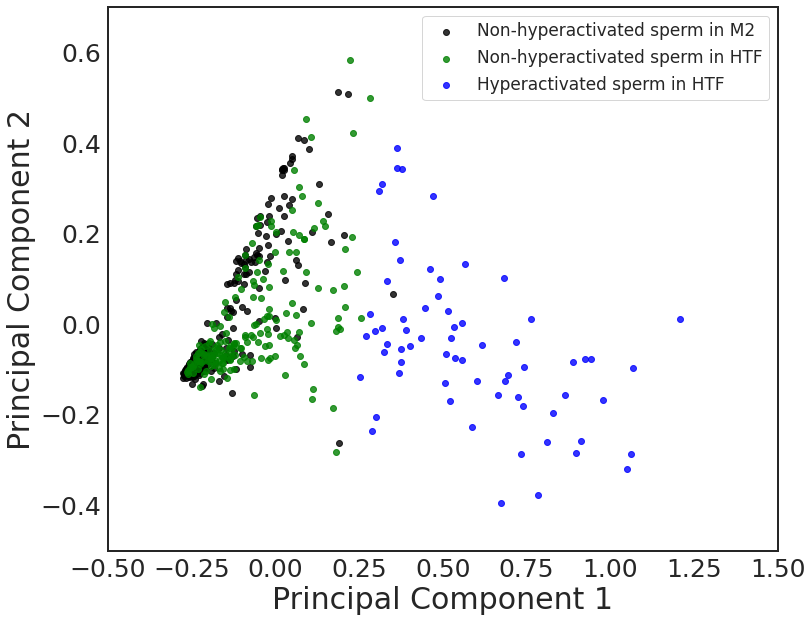

In [43]:
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
# ax.set_title('2 Components PCA', fontsize = 30)
for i in range(seg[0]):
    kdot=ax.scatter(principalDF_all.loc[i,'principal component 1'],principalDF_all.loc[i,'principal component 2'],c='k',alpha=0.8)
for i in range(len(mm_pca_HTF_non)):
    if r[1][i]>0.5:
        bdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='b',alpha=0.8)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='g',alpha=0.8)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.legend([kdot,gdot,bdot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF'],fontsize=17)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 0.7)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/PCA_Kmean_BS_MV_model')
plt.show()

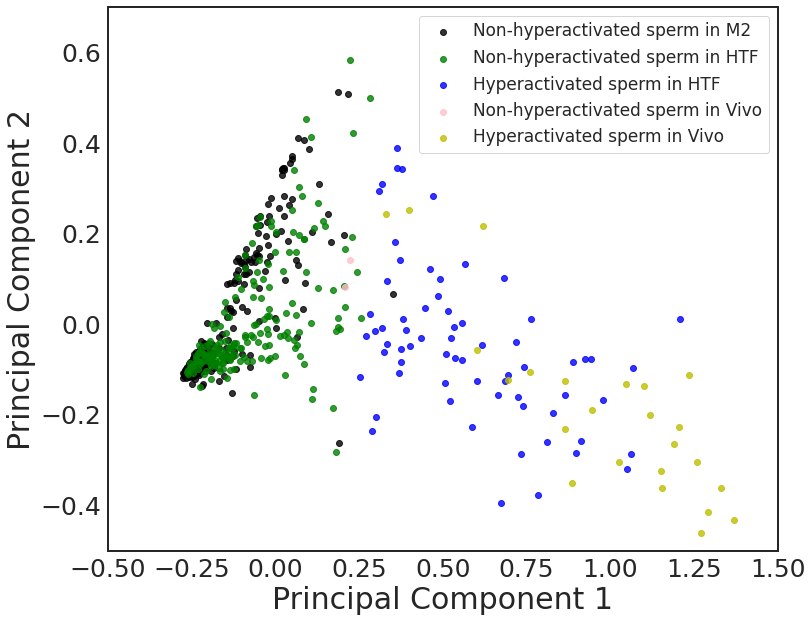

In [44]:
nhym2=[]
modhyidx,modnhyidx=[],[]
hyivo,nhyivo=[],[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
# ax.set_title('2 Components PCA', fontsize = 30)
for i in range(seg[0]):
    kdot=ax.scatter(principalDF_all.loc[i,'principal component 1'],principalDF_all.loc[i,'principal component 2'],c='k',alpha=0.8)
    if r[0][i]<0.5:
        nhym2.append(i)
for i in range(len(mm_pca_HTF_non)):
    if r[1][i]>0.5:
        bdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='b',alpha=0.8)
        modhyidx.append(seg[0]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='g',alpha=0.8)
        modnhyidx.append(seg[0]+i)
for i in range(len(mm_pca_invivo)):
    if r[2][i]>0.5:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
        hyivo.append(seg[1]+i)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
        nhyivo.append(seg[1]+i)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.legend([kdot,gdot,bdot,pdot,ydot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF','Non-hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo'],fontsize=17)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 0.7)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/PCA_Kmean_BS_MV_model_with_invivo')
plt.show()

In [45]:
len(nhym2),len(modhyidx),len(modnhyidx),len(hyivo),len(nhyivo)

(253, 67, 186, 24, 2)

In [46]:
len(modhyidx)/(len(modhyidx)+len(modnhyidx))*100,len(hyivo)/(len(hyivo)+len(nhyivo))*100

(26.48221343873518, 92.3076923076923)

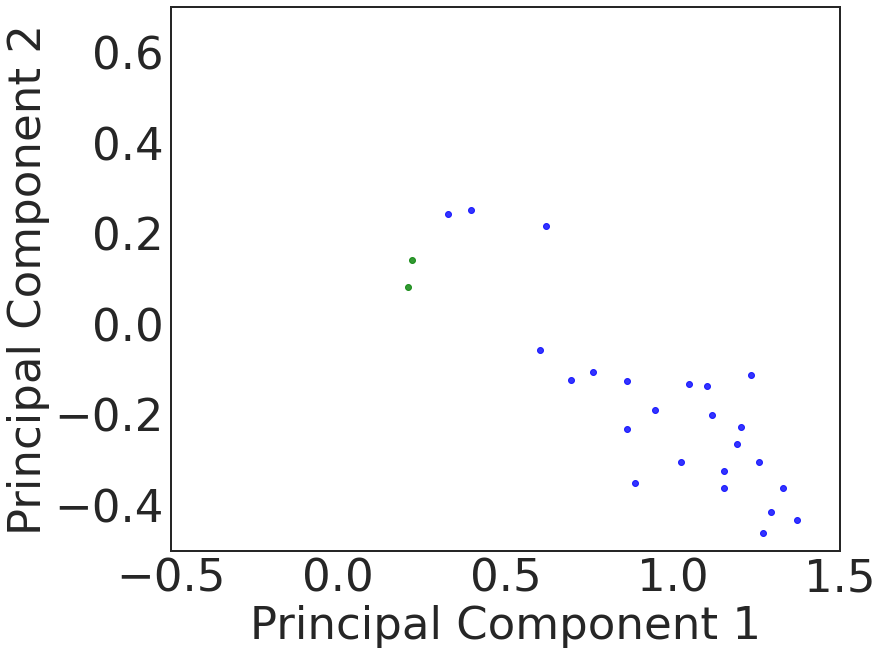

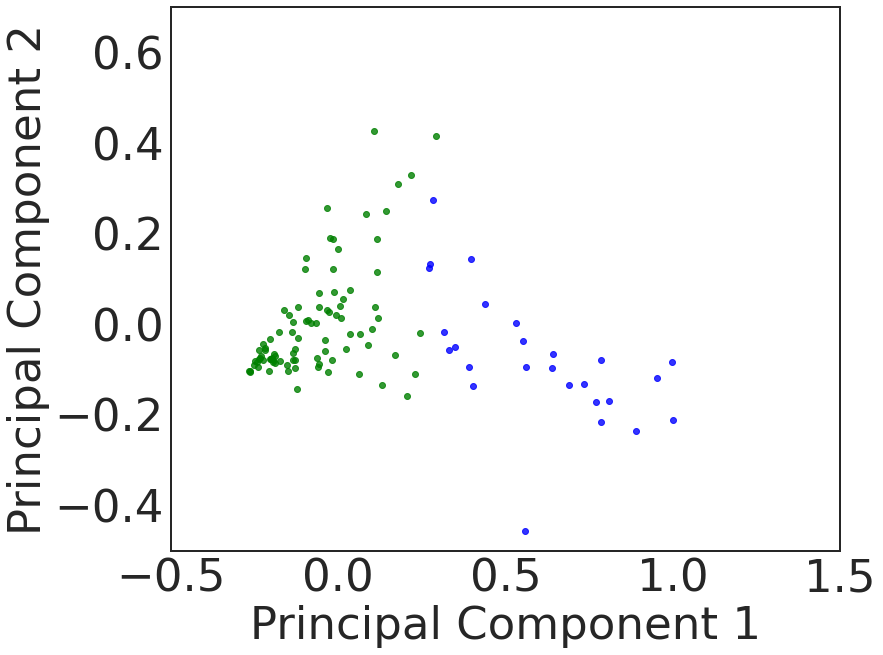

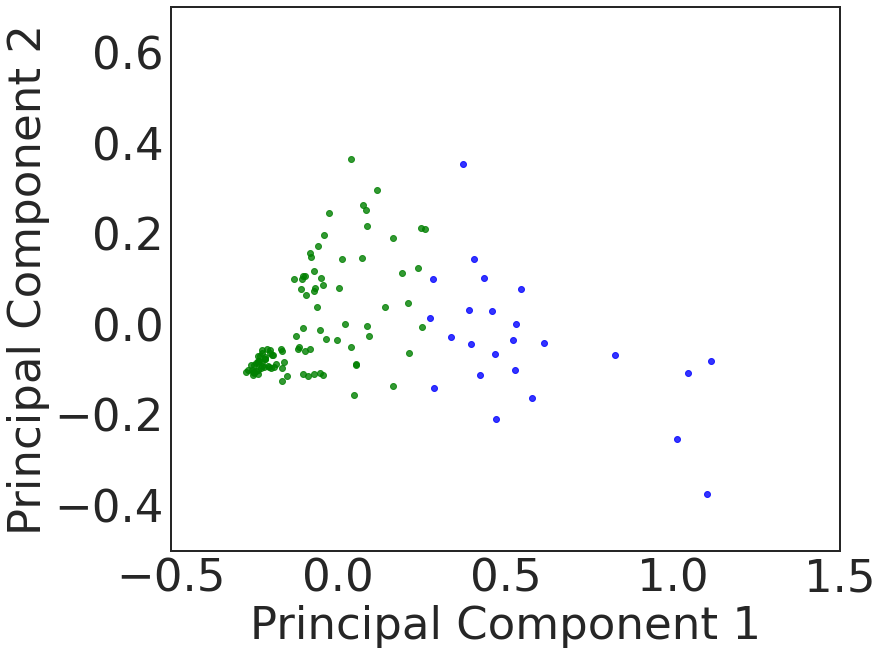

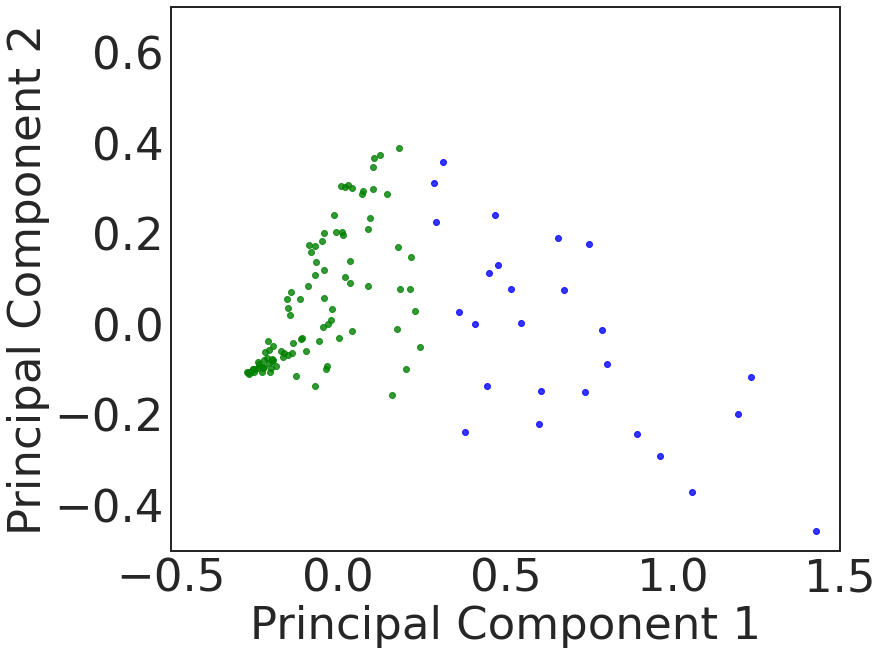

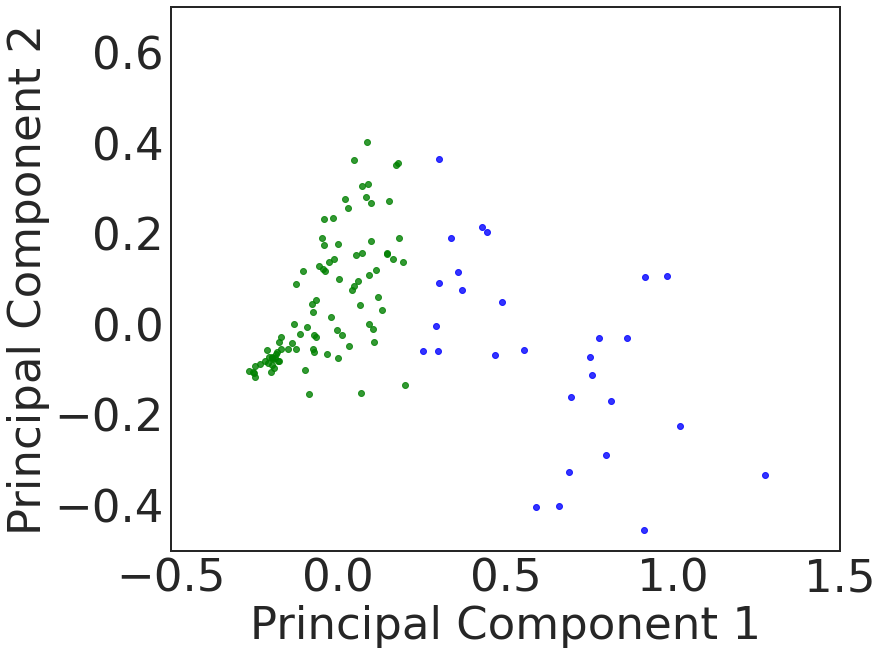

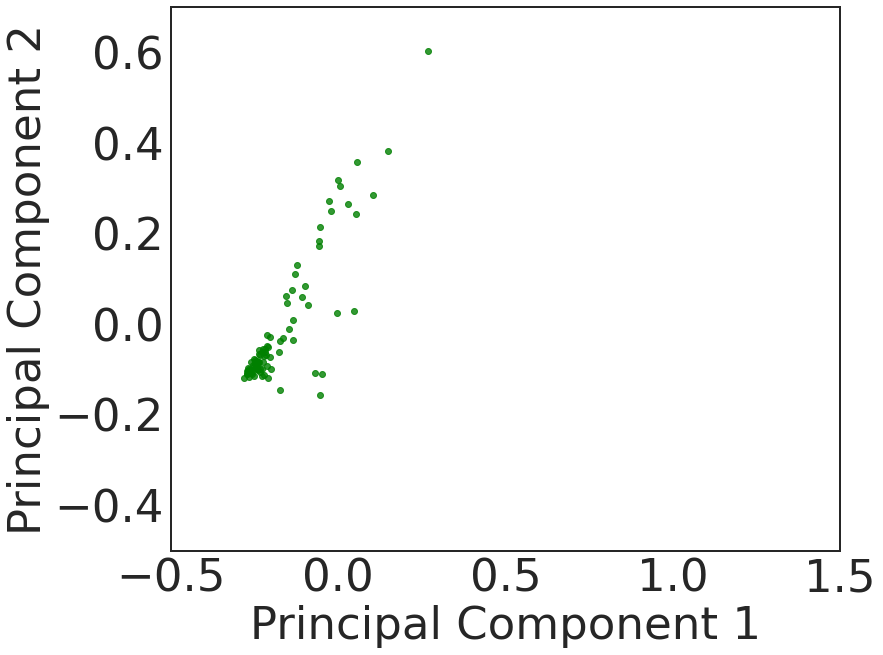

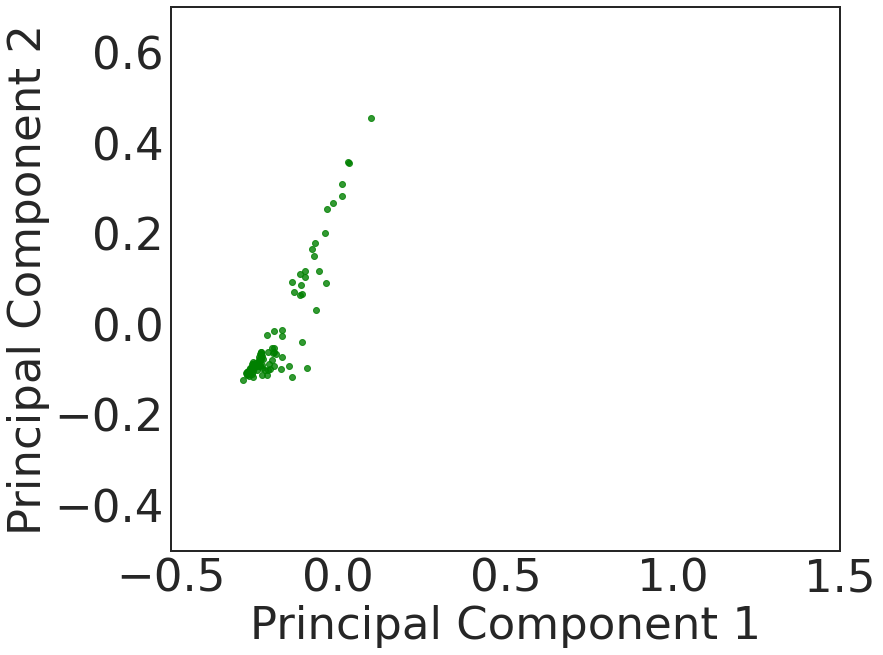

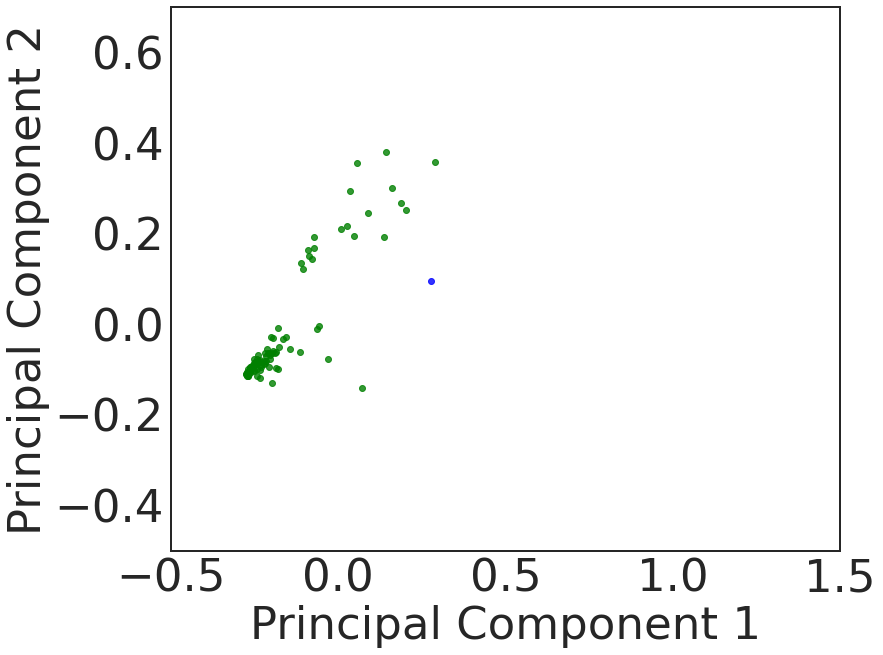

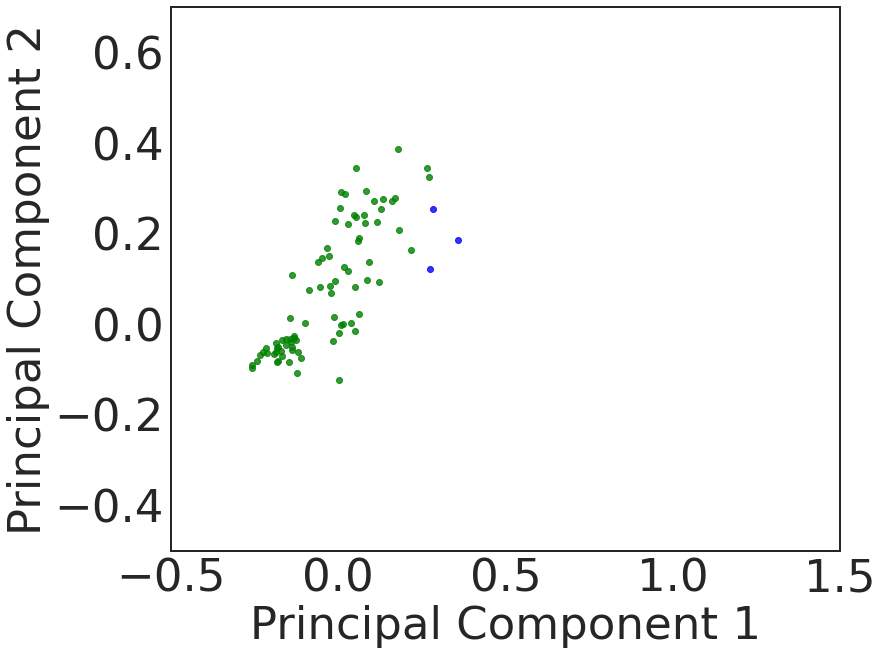

In [47]:
HyperVis=[]
for k in range(2,11):
  hyidx,nhyidx=[],[]
  sns.set_style('white')
  fig = plt.figure(figsize = (12,10))
  ax = fig.add_subplot(1,1,1)
  # ax.set_title('2 Components PCA in {}'.format(plotList[k][3]), fontsize = 30)
  for i in range(len(plotList[k][0])):
      if r[k][i]>0.5:
          bdot=ax.scatter(principalDF_all.loc[plotList[k][1]+i,'principal component 1'],principalDF_all.loc[plotList[k][1]+i,'principal component 2'],c='b',alpha=0.8)
          hyidx.append(plotList[k][1]+i)
      else:
          gdot=ax.scatter(principalDF_all.loc[plotList[k][1]+i,'principal component 1'],principalDF_all.loc[plotList[k][1]+i,'principal component 2'],c='g',alpha=0.8)
          nhyidx.append(plotList[k][1]+i)
  HyperVis.append([len(hyidx),len(nhyidx)])
  ax.set_xlabel('Principal Component 1', fontsize = 45)
  ax.set_ylabel('Principal Component 2', fontsize = 45)
  ax.yaxis.set_tick_params(labelsize=45)
  ax.xaxis.set_tick_params(labelsize=45)
  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
  # ax.legend([gdot,bdot],['Non-hyperactivated sperm in {}'.format(plotList[k][3]),'Hyperactivated sperm in {}'.format(plotList[k][3])],fontsize=17)
  plt.xlim(-0.5, 1.5)
  plt.ylim(-0.5, 0.7)
  plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/PCA_Kmean_BS_MV_{}.png'.format(plotList[k][3]))
  plt.show()

In [48]:
HyperVis

[[24, 2],
 [26, 91],
 [24, 99],
 [26, 95],
 [28, 90],
 [0, 92],
 [0, 97],
 [1, 92],
 [3, 81]]

In [49]:
[x[0]/(x[0]+x[1])*100 for x in HyperVis]

[92.3076923076923,
 22.22222222222222,
 19.51219512195122,
 21.487603305785125,
 23.728813559322035,
 0.0,
 0.0,
 1.0752688172043012,
 3.571428571428571]

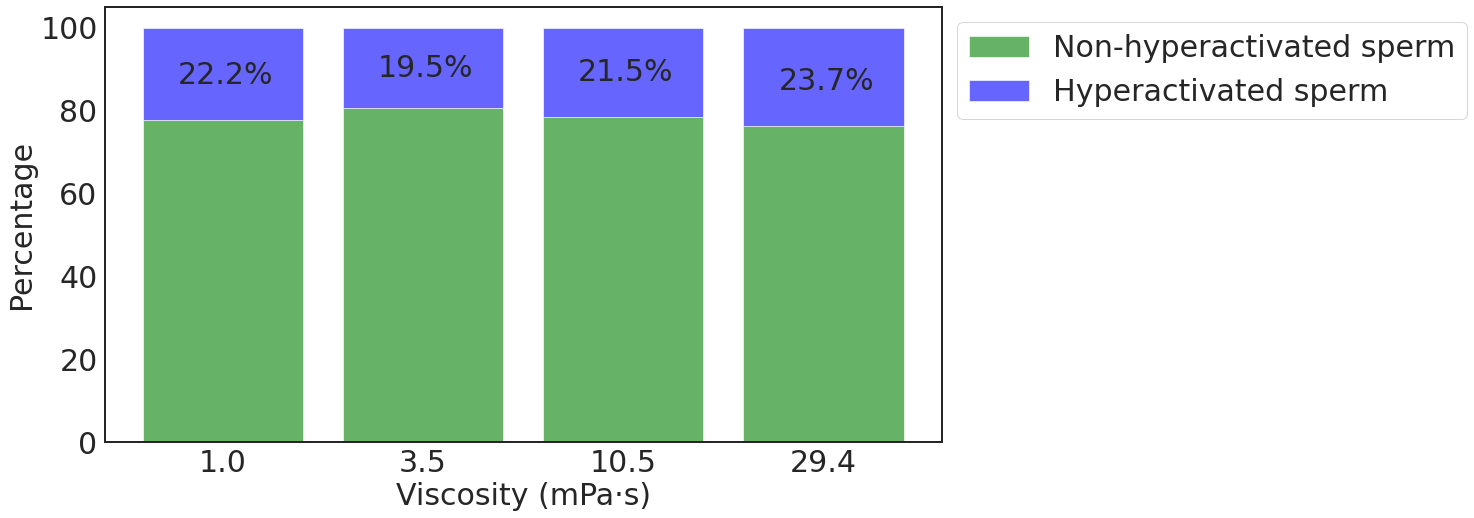

In [50]:
from seaborn.rcmod import set_style
vis=['1.0','3.5','10.5','29.4']
hy=[x[0]/(x[0]+x[1])*100 for x in HyperVis[1:5]]
nhy=[x[1]/(x[0]+x[1])*100 for x in HyperVis[1:5]]
x=np.arange(len(vis))
sns.set_style('white')
fig=plt.figure(figsize=(15,8))
ax=fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.bar(x, nhy, color='g', label='Non-hyperactivated sperm',alpha=0.6)
plt.bar(x, hy, color='b', label='Hyperactivated sperm',alpha=0.6, bottom=nhy)
for i in range(len(hy)):
  plt.annotate((str(round(hy[i]/(hy[i]+nhy[i])*100,1))+'%'),(x[i],(hy[i]//3+nhy[i])),textcoords="offset points",xytext=(-45,7),size=30)
plt.xticks(x, vis,size=30)
plt.yticks(size=30)
plt.xlabel('Viscosity (mPa·s)',fontsize=30)
plt.ylabel('Percentage',fontsize=30)
# plt.title('Hyperactivation Rate of HTF',fontsize=35)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/Vis_Res_HyperRate_BS_MV',bbox_inches='tight',dpi=300)
plt.show()

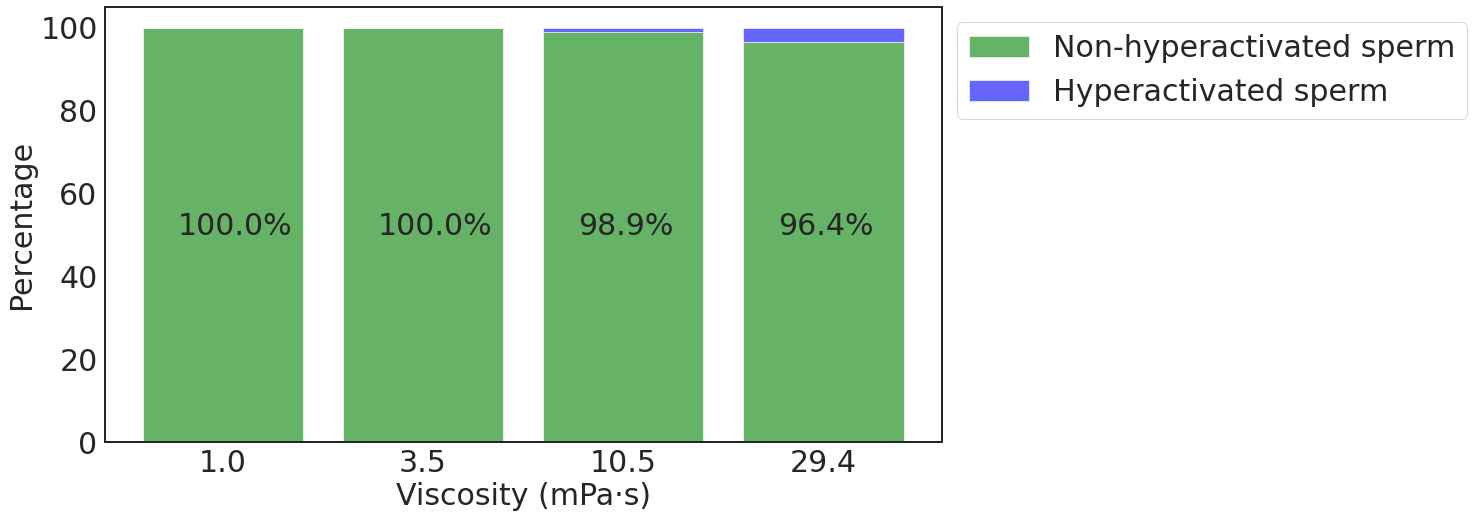

In [51]:
from seaborn.rcmod import set_style
vis=['1.0','3.5','10.5','29.4']
hy=[x[0]/(x[0]+x[1])*100 for x in HyperVis[5:]]
nhy=[x[1]/(x[0]+x[1])*100 for x in HyperVis[5:]]
x=np.arange(len(vis))
sns.set_style('white')
fig=plt.figure(figsize=(15,8))
ax=fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.bar(x, nhy, color='g', label='Non-hyperactivated sperm',alpha=0.6)
plt.bar(x, hy, color='b', label='Hyperactivated sperm',alpha=0.6, bottom=nhy)
for i in range(len(hy)):
  plt.annotate((str(round(nhy[i]/(hy[i]+nhy[i])*100,1))+'%'),(x[i],50),textcoords="offset points",xytext=(-45,0),size=30)
plt.xticks(x, vis,size=30)
plt.yticks(size=30)
plt.xlabel('Viscosity (mPa·s)',fontsize=30)
plt.ylabel('Percentage',fontsize=30)
plt.ylim(0,105)
# plt.title('Hyperactivation Rate of M2',fontsize=35)
plt.legend(bbox_to_anchor=(1,1),fontsize=30)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/Vis_Res_HyperRate_BS_MV_M2',bbox_inches='tight',dpi=300)
plt.show()

# **SwarmPlot over numerous parameters**

In [52]:
df_mod_ntc=principalDF_all.iloc[:seg[0]]
df_mod_hy=principalDF_all.iloc[modhyidx]
df_mod_nhy=principalDF_all.iloc[modnhyidx]
ntcPara,hyPara,nhyPara=[],[],[]
for e in ['SDofDV','LIN','STR','WOB']:
  for _ in range(len(modhyidx)):
    hyPara.append(e)
  for _ in range(len(modnhyidx)):
    nhyPara.append(e)
  for _ in range(len(df_mod_ntc)):
    ntcPara.append(e)

In [53]:
df_reshaped_ntc=pd.DataFrame(data={'Percentage':pd.concat([df_mod_ntc['SDofDV'],df_mod_ntc['LIN'],df_mod_ntc['STR'],df_mod_ntc['WOB']],ignore_index=True),'Paras':ntcPara,'Med':['M2']*(4*len(df_mod_ntc)),'Hy':[0]*(4*len(df_mod_ntc))})
df_reshaped_hy=pd.DataFrame(data={'Percentage':pd.concat([df_mod_hy['SDofDV'],df_mod_hy['LIN'],df_mod_hy['STR'],df_mod_hy['WOB']],ignore_index=True),'Paras':hyPara,'Med':['HTF']*(4*len(df_mod_hy)),'Hy':[1]*(4*len(df_mod_hy))})
df_reshaped_nhy=pd.DataFrame(data={'Percentage':pd.concat([df_mod_nhy['SDofDV'],df_mod_nhy['LIN'],df_mod_nhy['STR'],df_mod_nhy['WOB']],ignore_index=True),'Paras':nhyPara,'Med':['HTF']*(4*len(df_mod_nhy)),'Hy':[0]*(4*len(df_mod_nhy))})
df_swarm1=pd.concat([df_reshaped_ntc.loc[[i for i in range(len(df_reshaped_ntc)) if i%2!=0]],df_reshaped_nhy])
df_swarm2=pd.concat([df_reshaped_ntc.loc[[i for i in range(len(df_reshaped_ntc)) if i%2==0]],df_reshaped_hy])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 33.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 54.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 35.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.0% of the points cannot be placed; yo

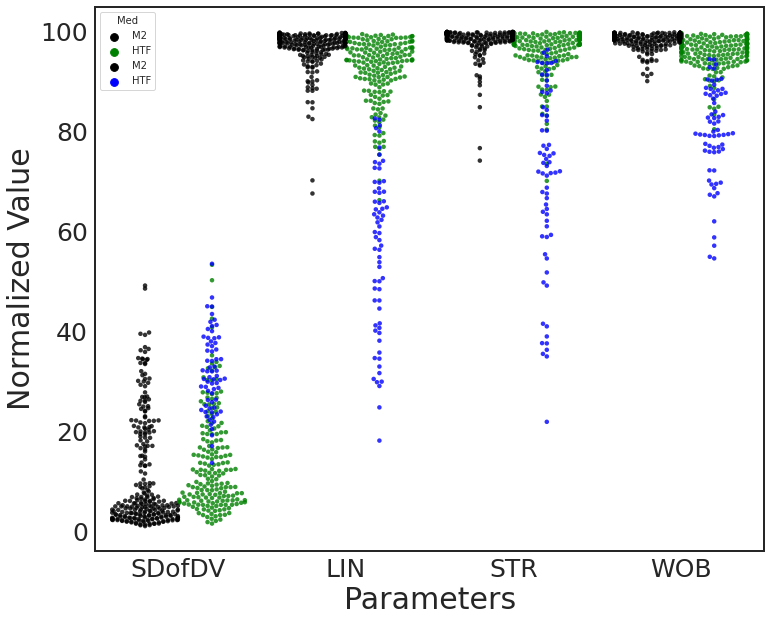

In [54]:
from matplotlib.patches import bbox_artist
from pandas.plotting import boxplot_frame
fig = plt.figure(figsize = (12,10))
ax=fig.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
sns.swarmplot(x ="Paras", y = "Percentage", hue="Med", data = df_swarm1, size = 4.5, palette=["k","g"],alpha=0.8, dodge=True)
sns.swarmplot(x ="Paras", y = "Percentage", hue="Med", data = df_swarm2, size = 4.5, palette=["k","b"],alpha=0.8, dodge=True)
plt.xlabel('Parameters',fontsize=30)
plt.ylabel('Normalized Value',fontsize=30)
plt.xticks(size=25)
plt.yticks(size=25)
# plt.legend(bbox_to_anchor=(1,1),frameon=False,fontsize=30)
plt.savefig("/content/drive/MyDrive/071422_sperm_mod/Kmean_BS_swarm_plot")
plt.show()

# **Invivo Hyperactivated Trajectories demo in 2D projections and 3D**

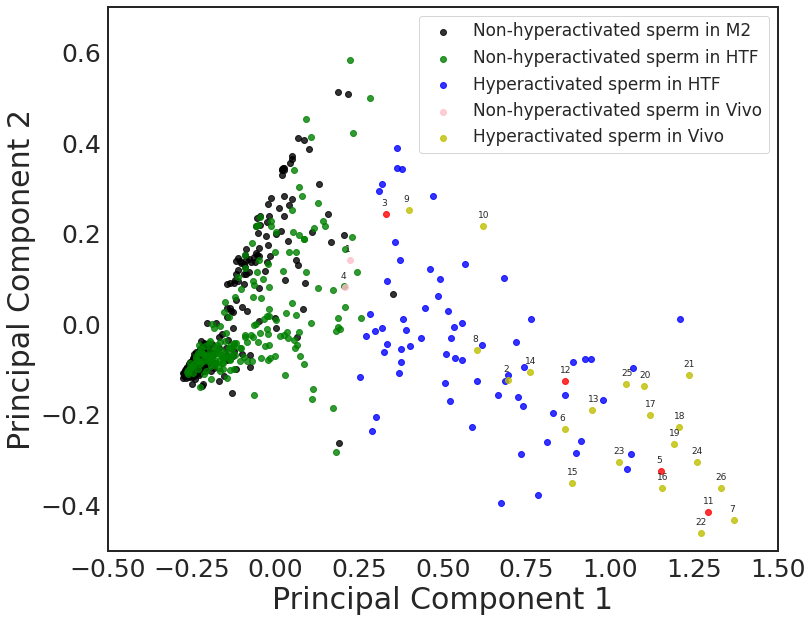

In [55]:
nhym2=[]
modhyidx,modnhyidx=[],[]
hyivo,nhyivo=[],[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
# ax.set_title('2 Components PCA', fontsize = 30)
for i in range(seg[0]):
    kdot=ax.scatter(principalDF_all.loc[i,'principal component 1'],principalDF_all.loc[i,'principal component 2'],c='k',alpha=0.8)
    if r[0][i]<0.5:
        nhym2.append(i)
for i in range(len(mm_pca_HTF_non)):
    if r[1][i]>0.5:
        bdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='b',alpha=0.8)
        modhyidx.append(seg[0]+i)
    else:
        gdot=ax.scatter(principalDF_all.loc[seg[0]+i,'principal component 1'],principalDF_all.loc[seg[0]+i,'principal component 2'],c='g',alpha=0.8)
        modnhyidx.append(seg[0]+i)
dic={3:1,12:2,5:3,11:4}
for i in range(len(mm_pca_invivo)):
    if r[2][i]>0.5:
        if i+1 not in dic:
          ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
        else:
          ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='r',alpha=0.8)
        ax.annotate(i+1,(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2']),textcoords="offset points",xytext=(-5,8),size=9)
        hyivo.append(seg[1]+i)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
        ax.annotate(i+1,(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2']),textcoords="offset points",xytext=(-5,8),size=9)
        nhyivo.append(seg[1]+i)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.legend([kdot,gdot,bdot,pdot,ydot],['Non-hyperactivated sperm in M2','Non-hyperactivated sperm in HTF','Hyperactivated sperm in HTF','Non-hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo'],fontsize=17)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 0.7)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/PCA_Kmean_BS_MV_model_with_invivo_all_label')
plt.show()

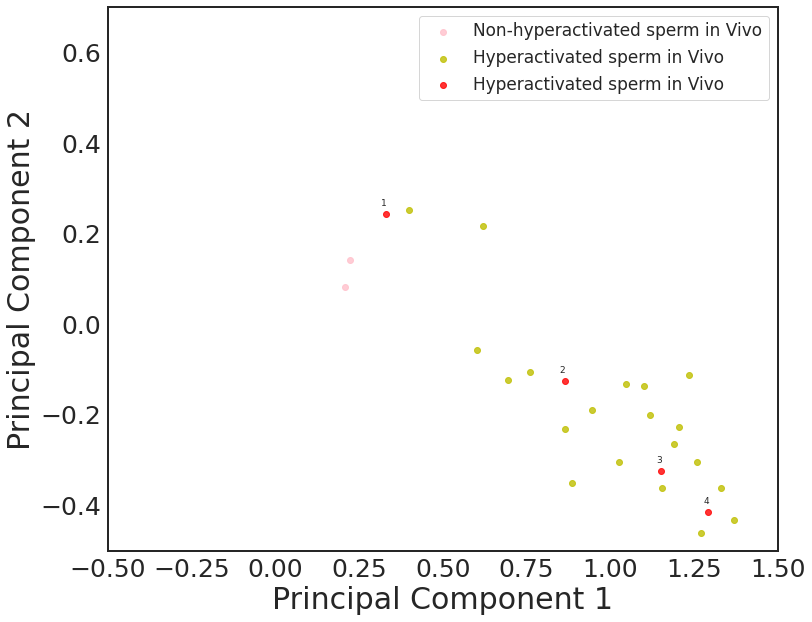

In [72]:
nhym2=[]
modhyidx,modnhyidx=[],[]
hyivo,nhyivo=[],[]
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
# ax.set_title('2 Components PCA', fontsize = 30)
dic={3:1,12:2,5:3,11:4}
for i in range(len(mm_pca_invivo)):
    if r[2][i]>0.5:
        if i+1 not in dic:
          ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
        else:
          rdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='r',alpha=0.8)
          ax.annotate(dic[i+1],(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2']),textcoords="offset points",xytext=(-5,8),size=9)
        hyivo.append(seg[1]+i)
    else:
        pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
        nhyivo.append(seg[1]+i)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.legend([pdot,ydot,rdot],['Non-hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo'],fontsize=17)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 0.7)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/PCA_Kmean_BS_MV_model_with_invivo_hy_label')
plt.show()

In [58]:
df_invivo_3=pd.read_csv('/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_3.csv')
df_invivo_5=pd.read_csv('/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_5.csv')
df_invivo_11=pd.read_csv('/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_11.csv')
df_invivo_12=pd.read_csv('/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_12.csv')

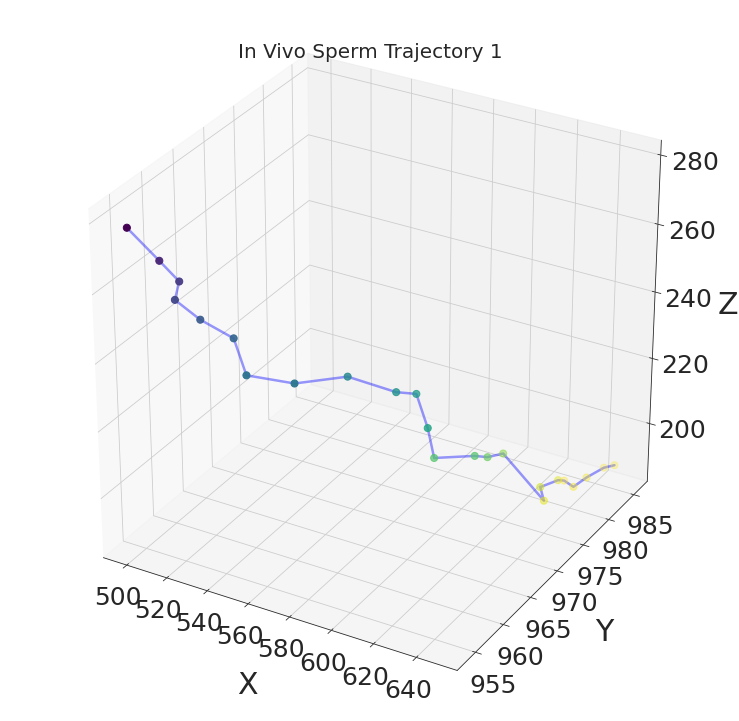

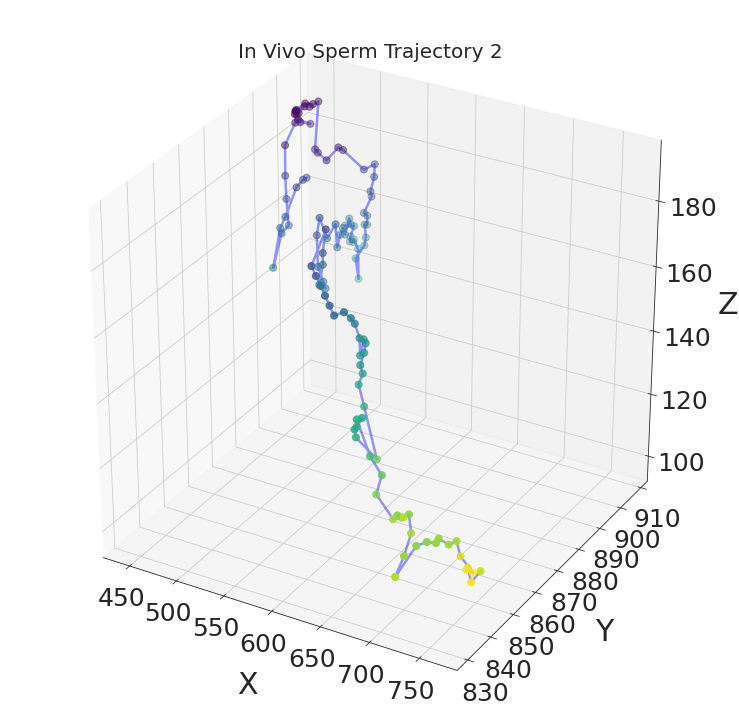

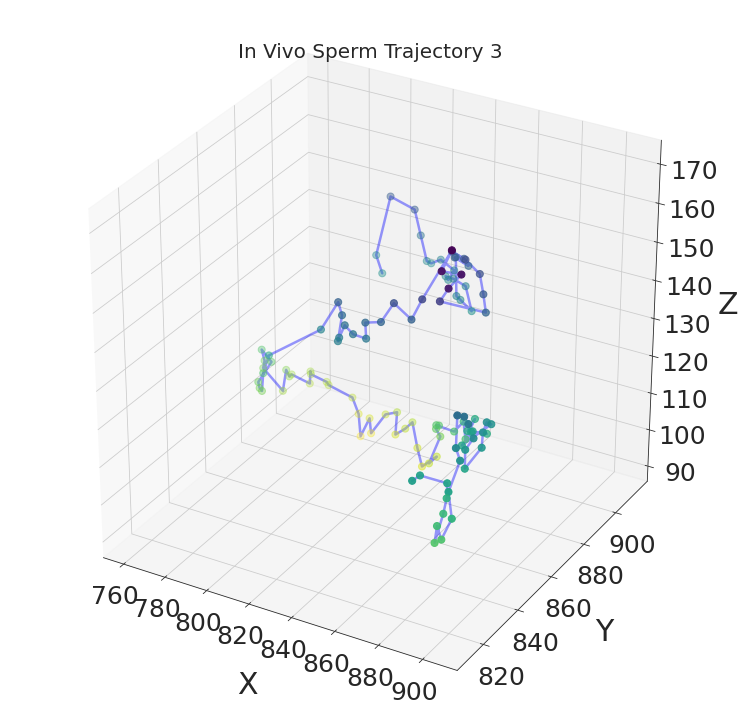

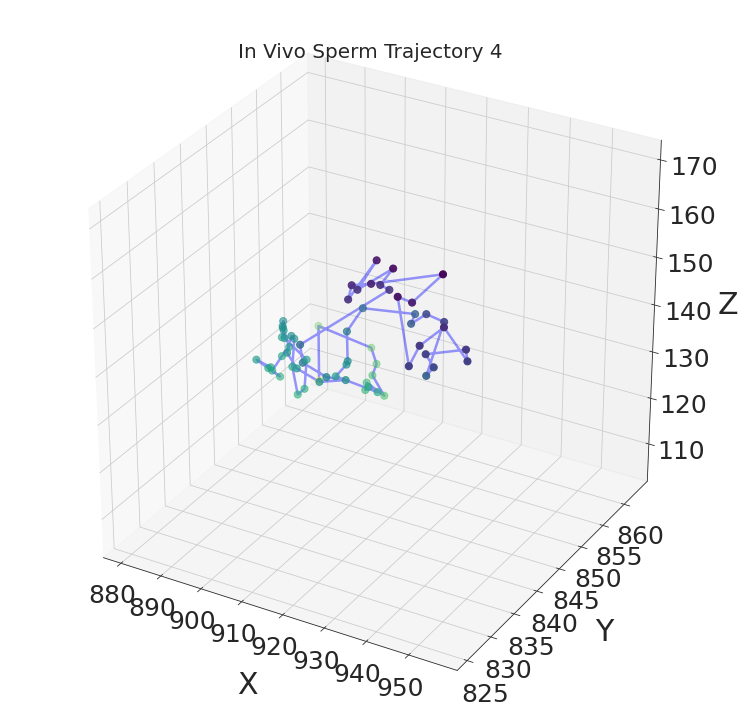

In [59]:
for i,df in enumerate([df_invivo_3,df_invivo_12,df_invivo_5,df_invivo_11]):
  fig = plt.figure(figsize=(13,13))
  sns.set_style('ticks')
  ax = plt.axes(projection='3d')
  xdata,ydata,zdata=df['Position X'],df['Position Y'],df['Position Z']
  ax.scatter3D(xdata,ydata,zdata,c=zdata,cmap='viridis_r',s=50,zorder=2)
  ax.plot(xdata,ydata,zdata,c='blue',linewidth=2.5,zorder=1,alpha=0.4)
  ax.set_xlabel('X',fontsize=30)
  ax.set_ylabel('Y',fontsize=30)
  ax.set_zlabel('Z',fontsize=30)
  ax.xaxis.labelpad=30
  ax.yaxis.labelpad=30
  ax.zaxis.labelpad=30
  ax.xaxis.set_tick_params(labelsize=25,pad=7)
  ax.yaxis.set_tick_params(labelsize=25,pad=10)
  ax.zaxis.set_tick_params(labelsize=25,pad=15)
  ax.set_title('In Vivo Sperm Trajectory {}'.format(i+1),fontsize=20)
  plt.autoscale()
  plt.savefig("/content/drive/MyDrive/071422_sperm_mod/082522_OCT_trj_in_vivo_select/3D_trj_in_vivo_select_{}.png".format(i+1),bbox_inches='tight',dpi=100)
  plt.show()

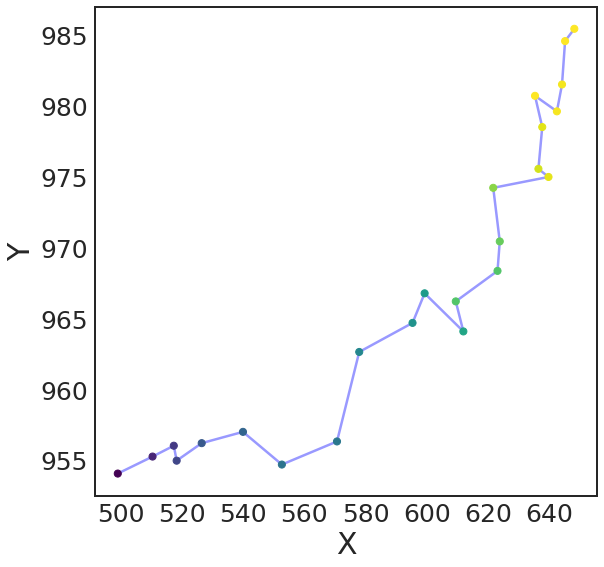

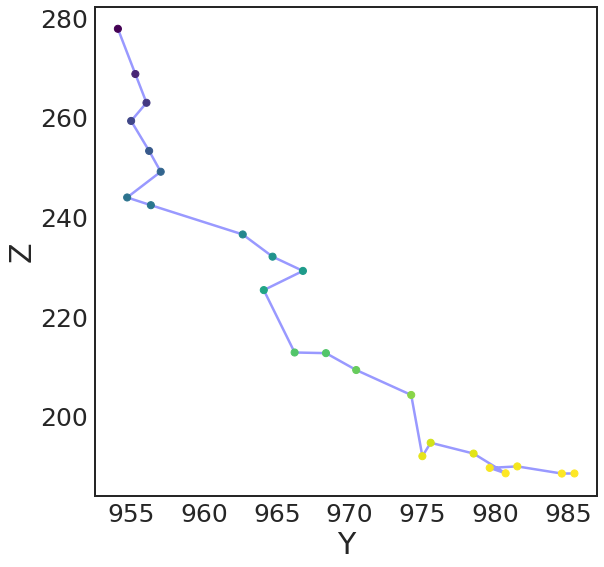

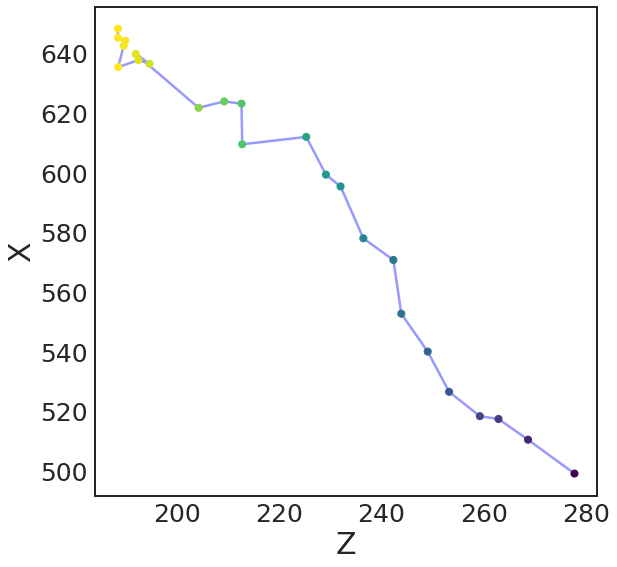

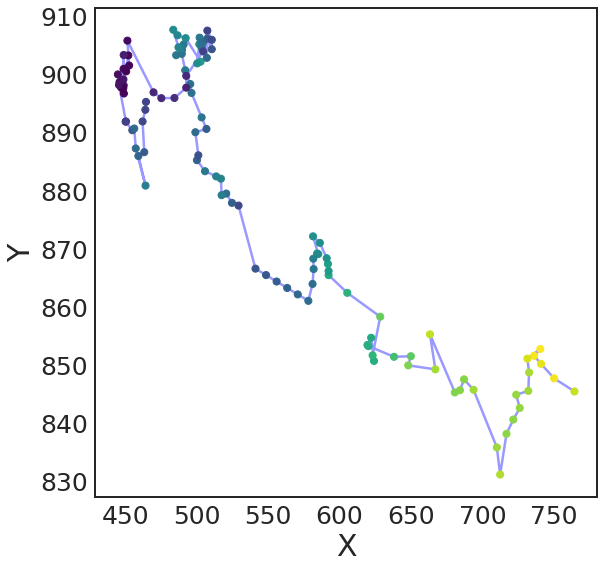

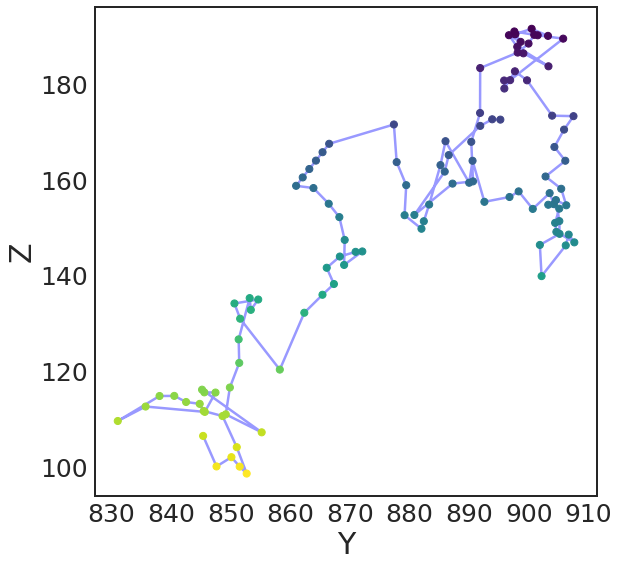

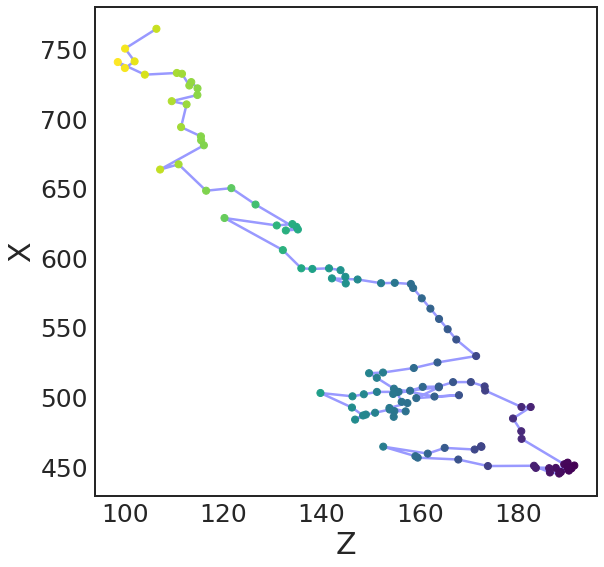

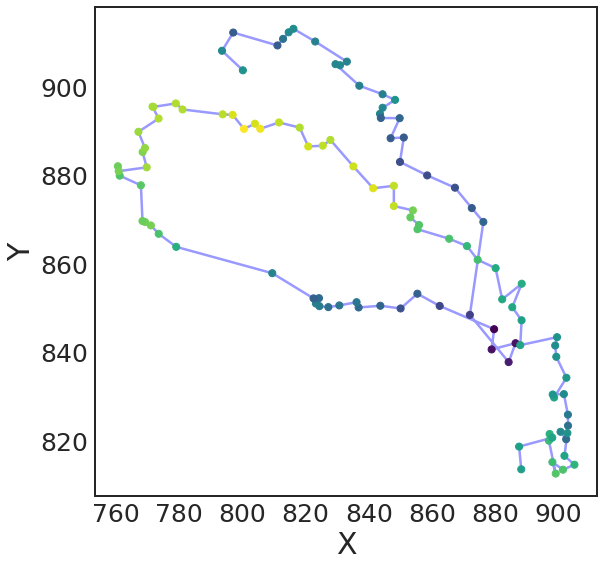

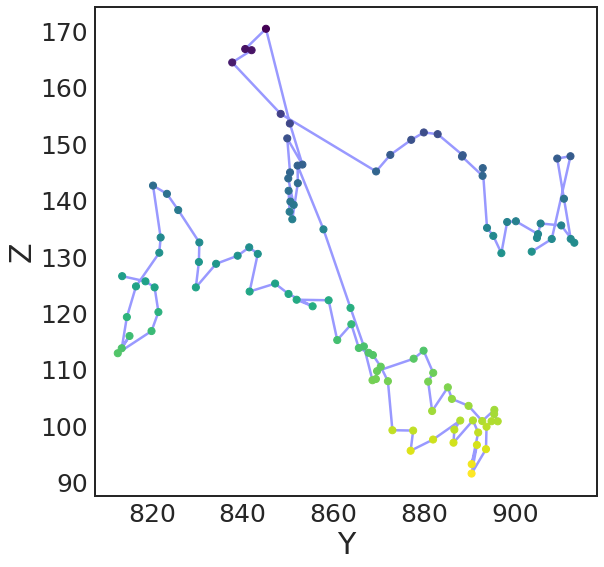

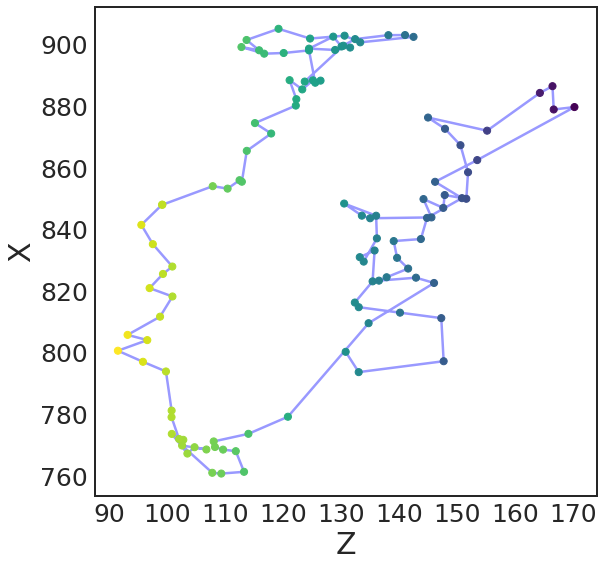

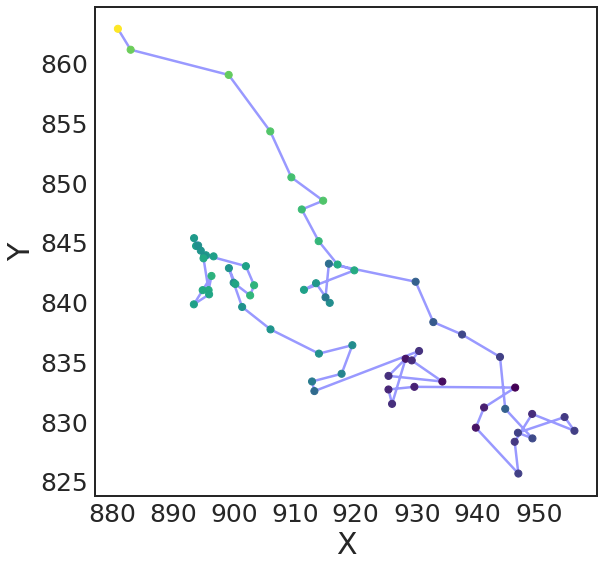

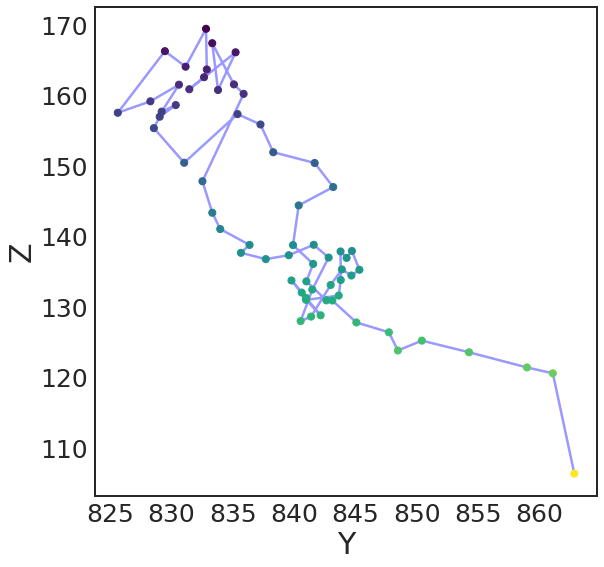

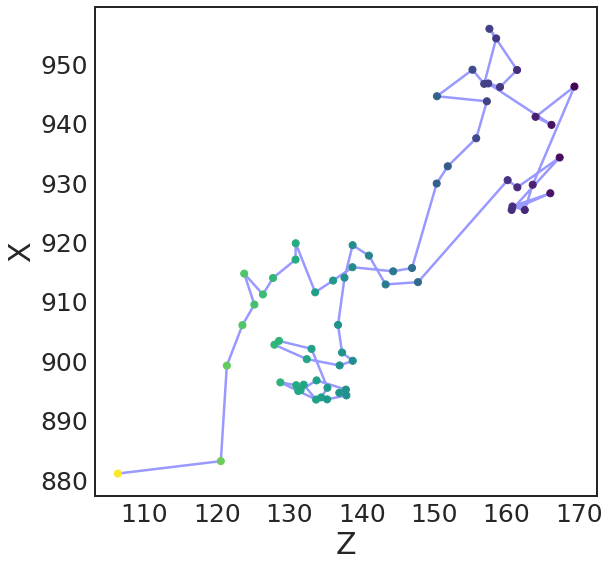

In [60]:
cols=['Position X','Position Y','Position Z','Position X']
labels=['X','Y','Z','X']
for i,df in enumerate([df_invivo_3,df_invivo_12,df_invivo_5,df_invivo_11]):
  for j in range(3):
    sns.set_style('white')
    fig=plt.figure(figsize=(9,9))
    ax=fig.gca()
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
    plt.scatter(df[cols[j]],df[cols[j+1]],c=df[cols[2]],cmap='viridis_r',s=50,zorder=2)
    plt.plot(df[cols[j]],df[cols[j+1]],c='blue',linewidth=2.5,zorder=1,alpha=0.4)
    # plt.title('2D({}{}) projection of in vivo sperm {}'.format(labels[j],labels[j+1],i+1),fontsize=20)
    plt.xlabel(labels[j],fontsize=30)
    plt.ylabel(labels[j+1],fontsize=30)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.savefig("/content/drive/MyDrive/071422_sperm_mod/082522_OCT_trj_in_vivo_select/2D_trj_in_vivo_select_{}_{}{}.png".format(i+1,labels[j],labels[j+1]),bbox_inches='tight',dpi=100)
    plt.show()

# **Invivo Non-hyperactivated Trajectories demo in 2D projections and 3D**

In [61]:
[x-seg[1] for x in nhyivo]

[0, 3]

In [62]:
principalDF_all.loc[nhyivo,['SDofDV','LIN','STR','WOB']]

,SDofDV,LIN,STR,WOB
507,30.77946,80.297690,85.581242,93.826273
510,26.61874,79.739775,88.079757,90.531329


In [63]:
df_invivo_1=pd.read_csv('/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_1.csv')
df_invivo_4=pd.read_csv('/content/drive/MyDrive/071422_sperm_mod/InVivo_sperm/InVivo_sperm_4.csv')

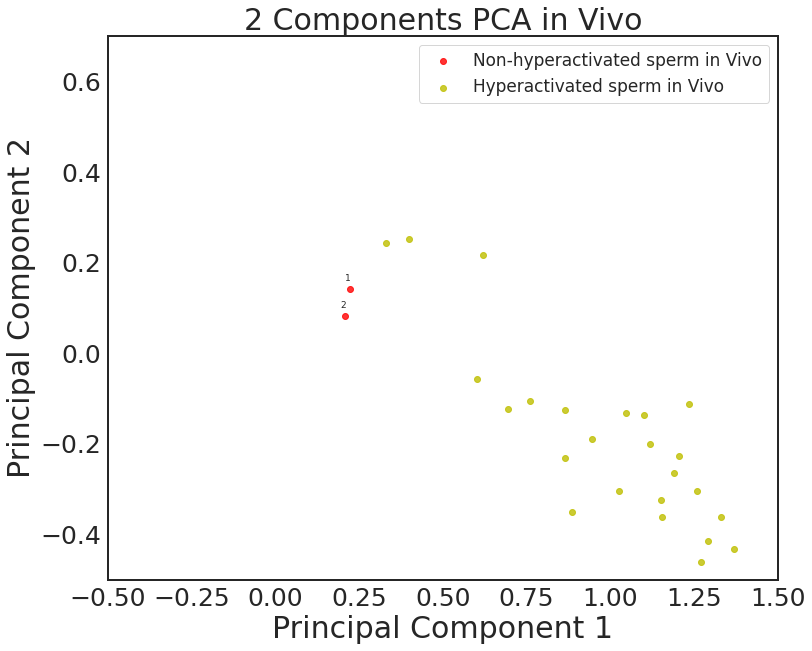

In [69]:
k=2
sns.set_style('white')
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Components PCA in {}'.format(plotList[k][3]), fontsize = 30)
dic={1:1,4:2}
for i in range(len(mm_pca_invivo)):
    if r[2][i]>0.5:
        ydot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='y',alpha=0.8)
        hyivo.append(seg[1]+i)
    else:
        if i+1 not in dic:
          pdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='pink',alpha=0.8)
        else:
          rdot=ax.scatter(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2'],c='r',alpha=0.8)
        ax.annotate(dic[i+1],(principalDF_all.loc[seg[1]+i,'principal component 1'],principalDF_all.loc[seg[1]+i,'principal component 2']),textcoords="offset points",xytext=(-5,8),size=9)
        nhyivo.append(seg[1]+i)
ax.set_xlabel('Principal Component 1', fontsize = 30)
ax.set_ylabel('Principal Component 2', fontsize = 30)
ax.yaxis.set_tick_params(labelsize=25)
ax.xaxis.set_tick_params(labelsize=25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.legend([rdot,ydot],['Non-hyperactivated sperm in Vivo','Hyperactivated sperm in Vivo'],fontsize=17)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 0.7)
plt.savefig('/content/drive/MyDrive/071422_sperm_mod/Agg/Majority_Vote/PCA_Kmean_BS_MV_model_with_invivo_nhy_label')
plt.show()

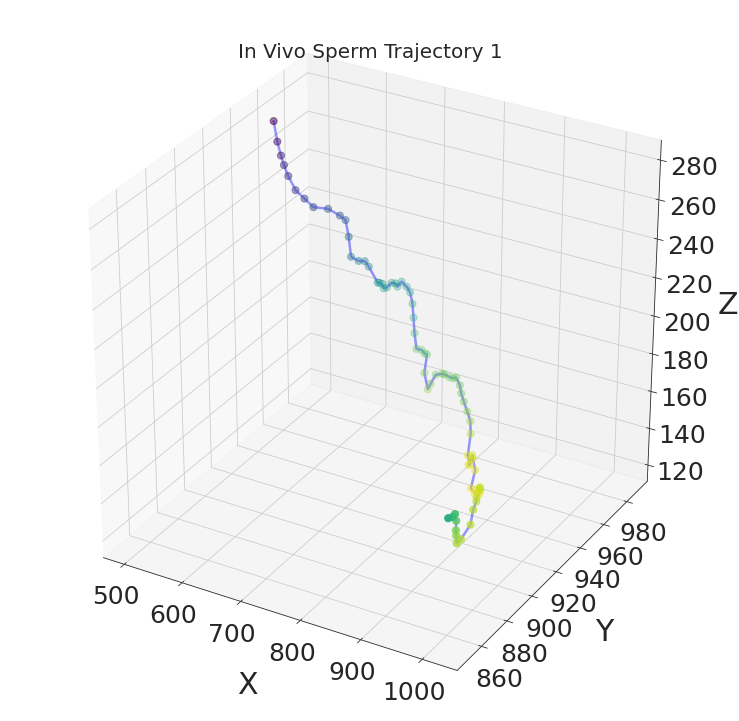

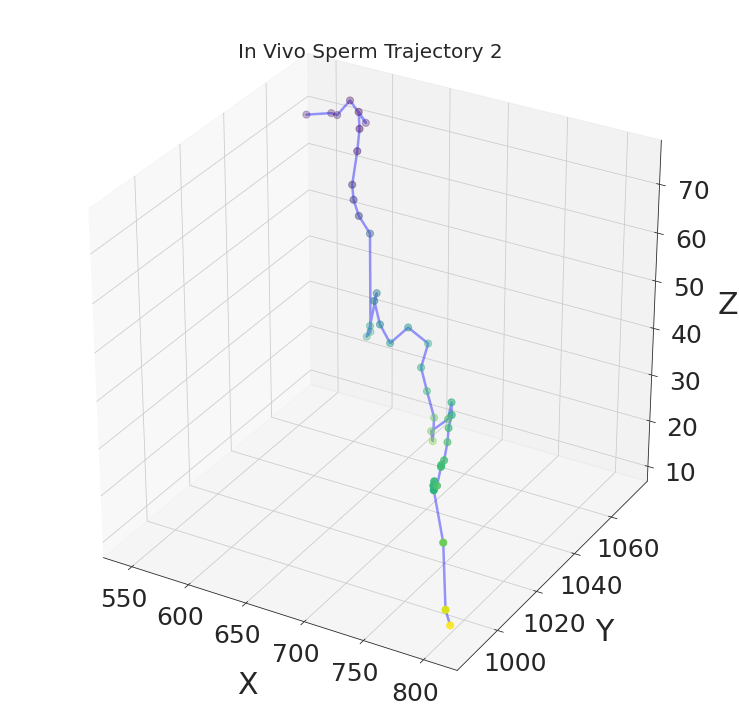

In [65]:
for i,df in enumerate([df_invivo_1,df_invivo_4]):
  fig = plt.figure(figsize=(13,13))
  sns.set_style('ticks')
  ax = plt.axes(projection='3d')
  xdata,ydata,zdata=df['Position X'],df['Position Y'],df['Position Z']
  ax.scatter3D(xdata,ydata,zdata,c=zdata,cmap='viridis_r',s=50,zorder=2)
  ax.plot(xdata,ydata,zdata,c='blue',linewidth=2.5,zorder=1,alpha=0.4)
  ax.set_xlabel('X',fontsize=30)
  ax.set_ylabel('Y',fontsize=30)
  ax.set_zlabel('Z',fontsize=30)
  ax.xaxis.labelpad=30
  ax.yaxis.labelpad=30
  ax.zaxis.labelpad=30
  ax.xaxis.set_tick_params(labelsize=25,pad=7)
  ax.yaxis.set_tick_params(labelsize=25,pad=10)
  ax.zaxis.set_tick_params(labelsize=25,pad=15)
  ax.set_title('In Vivo Sperm Trajectory {}'.format(i+1),fontsize=20)
  plt.autoscale()
  plt.savefig("/content/drive/MyDrive/071422_sperm_mod/082522_OCT_trj_in_vivo_select/3D_trj_in_vivo_nhy_{}.png".format(i+1),bbox_inches='tight',dpi=100)
  plt.show()

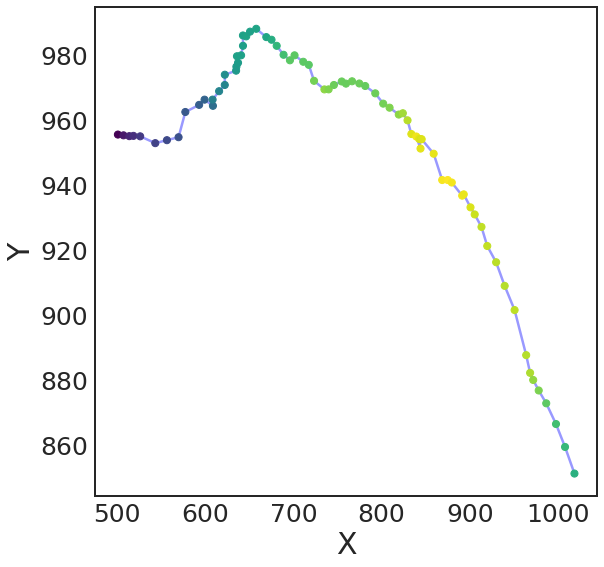

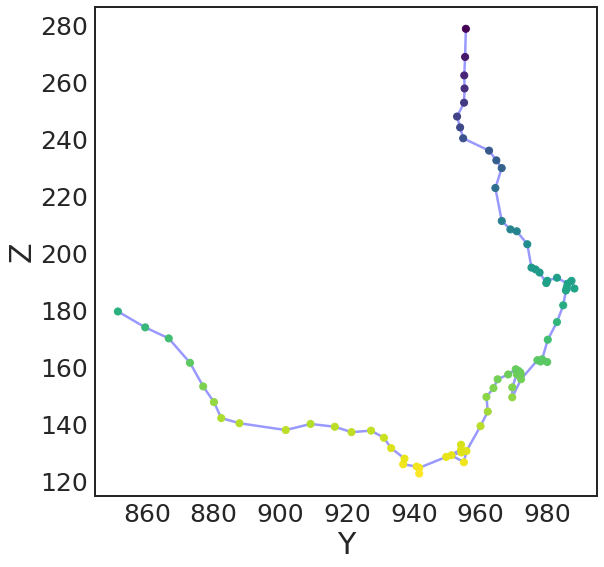

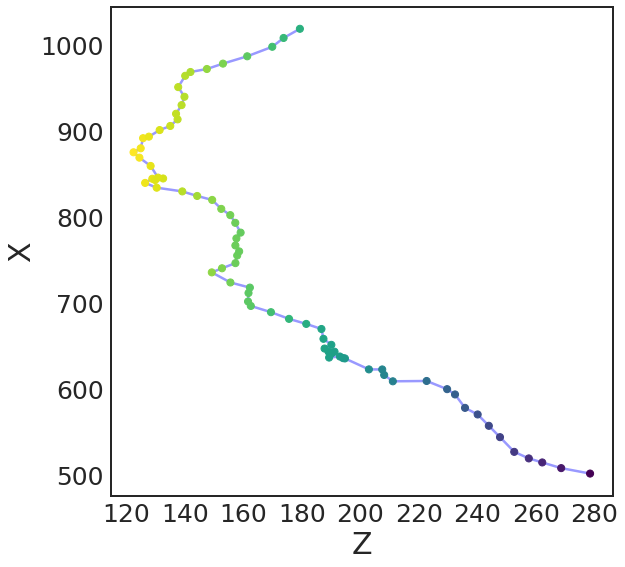

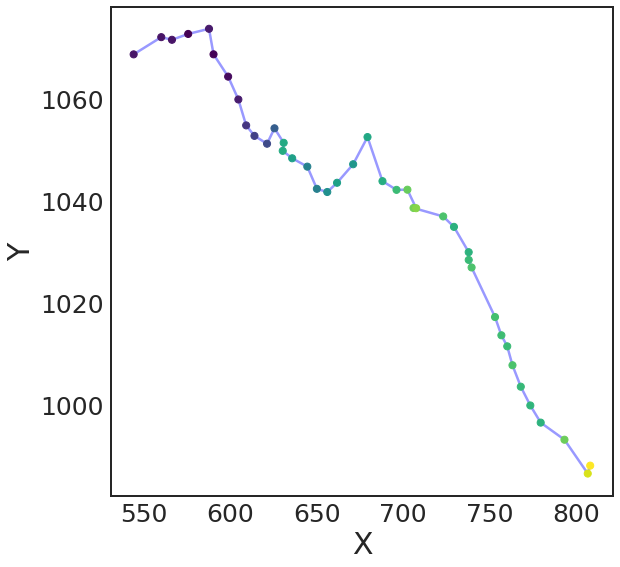

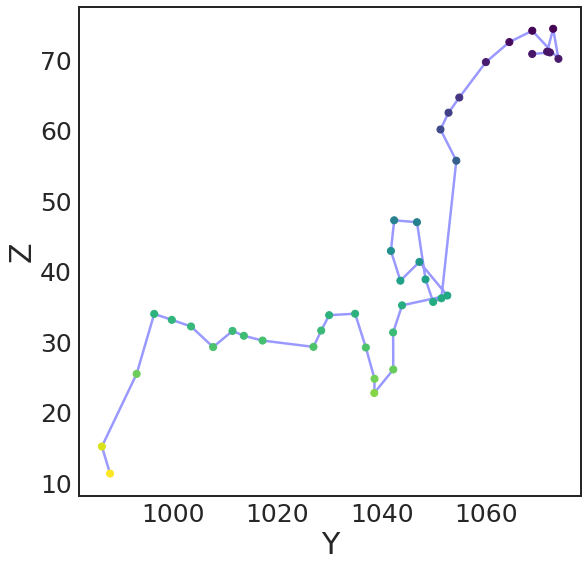

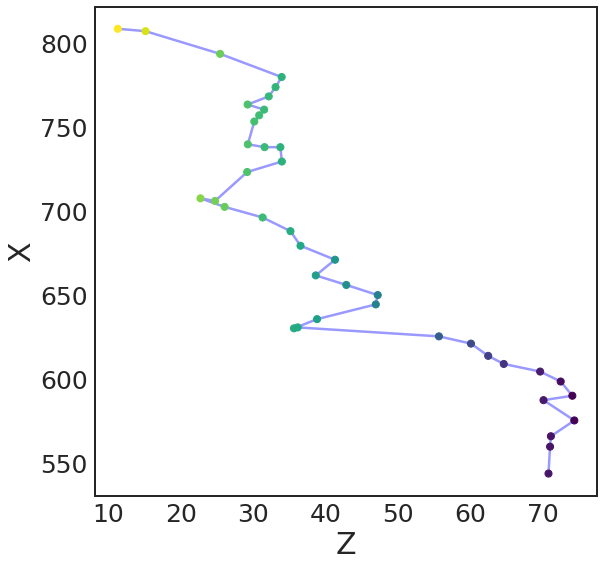

In [67]:
cols=['Position X','Position Y','Position Z','Position X']
labels=['X','Y','Z','X']
for i,df in enumerate([df_invivo_1,df_invivo_4]):
  for j in range(3):
    sns.set_style('white')
    fig=plt.figure(figsize=(9,9))
    ax=fig.gca()
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
    plt.scatter(df[cols[j]],df[cols[j+1]],c=df[cols[2]],cmap='viridis_r',s=50,zorder=2)
    plt.plot(df[cols[j]],df[cols[j+1]],c='blue',linewidth=2.5,zorder=1,alpha=0.4)
    # plt.title('2D({}{}) projection of in vivo sperm {}'.format(labels[j],labels[j+1],i+1),fontsize=20)
    plt.xlabel(labels[j],fontsize=30)
    plt.ylabel(labels[j+1],fontsize=30)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.savefig("/content/drive/MyDrive/071422_sperm_mod/082522_OCT_trj_in_vivo_select/2D_trj_in_vivo_nhy_select_{}_{}{}.png".format(i+1,labels[j],labels[j+1]),bbox_inches='tight',dpi=100)
    plt.show()